# Ordinary Exam 2022 - Measuring diversification and optimal portfolios

# Guided Solution

Below, I will examplify how to solve the problems. I will not, necessarily, provide the full solution. 

Results may depend on modelling choices. 

# Packages

Imported functions and modules are used for solving both problems. 

In [1]:
import sys
sys.path.insert(0,'C:\\code\\python_for_the_financial_economist\\')

"""
Magic commands
"""

%load_ext autoreload
%autoreload 2

"""
Python packages
"""

import numpy as np
import seaborn as sns
from scipy import stats, optimize
import pandas as pd
import matplotlib.pyplot as plt
import datetime

# remember to install pandas-datareader  if not installed
from pandas_datareader.famafrench import FamaFrenchReader, get_available_datasets

"""
Own packages
"""

import codelib.portfolio_optimization.diversification as dm
import codelib.portfolio_optimization.risk_budget as rb
import codelib.portfolio_optimization.risk_metrics as rm

from codelib.portfolio_optimization.risk_budget import calculate_marginal_risks_cvar, calculate_risk_contributions_cvar

# exponential probabilites
from codelib.statistics.historical_probabilities import calculate_exponential_decay_probabilities

# covariance estimator 
from codelib.statistics.moments import calculate_cov_mat, cov_to_corr_matrix, corr_to_cov_matrix
from codelib.statistics.moments import calculate_log_norm_cov_mat, calculate_log_norm_mean

# plotting
from codelib.visualization.layout import DefaultStyle, default_colors
from codelib.visualization.base import fan_chart, risk_waterfall_chart, waterfall_chart
DefaultStyle();

# Problem 1: Portfolio diversification

## Industry Portfolios

In [2]:
"""
Obtain Fama-French Industry portfolios since 1970
"""

ff_dict = FamaFrenchReader('49_Industry_Portfolios', start='1970-01-01').read()

ff_daily_dict = FamaFrenchReader('49_Industry_Portfolios_Daily', start='1970-01-01').read()  # , end='2020-01-01'

In [3]:
ff_dict['DESCR']

'49 Industry Portfolios\n----------------------\n\nThis file was created by CMPT_IND_RETS using the 202211 CRSP database. It contains value- and equal-weighted returns for 49 industry portfolios. The portfolios are constructed at the end of June. The annual returns are from January to December. Missing data are indicated by -99.99 or -999. Copyright 2022 Kenneth R. French\n\n  0 : Average Value Weighted Returns -- Monthly (635 rows x 49 cols)\n  1 : Average Equal Weighted Returns -- Monthly (635 rows x 49 cols)\n  2 : Average Value Weighted Returns -- Annual (52 rows x 49 cols)\n  3 : Average Equal Weighted Returns -- Annual (52 rows x 49 cols)\n  4 : Number of Firms in Portfolios (635 rows x 49 cols)\n  5 : Average Firm Size (635 rows x 49 cols)\n  6 : Sum of BE / Sum of ME (53 rows x 49 cols)\n  7 : Value-Weighted Average of BE/ME (53 rows x 49 cols)'

In [4]:
ff_daily_dict['DESCR']

'49 Industry Portfolios Daily\n----------------------------\n\nThis file was created by CMPT_IND_RETS_DAILY using the 202211 CRSP database. It contains value- and equal-weighted returns for 49 industry portfolios. The portfolios are constructed at the end of June. Missing data are indicated by -99.99 or -999. Copyright 2022 Kenneth R. French\n\n  0 : Average Value Weighted Returns -- Daily (13348 rows x 49 cols)\n  1 : Average Equal Weighted Returns -- Daily (13348 rows x 49 cols)'

In [5]:
# market capitialization for each sector 
df_mc = ff_dict[4] * ff_dict[5]

# total market cap. for each month
total_mc =  df_mc.sum(axis=1)

# relative weights 
df_weights = df_mc.divide(total_mc, axis=0 ) 

# show weights
df_weights.head()

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
Date,,,,,,,,,,,,,,,,,,,,,
1970-01,0.000548,0.028208,0.011335,0.005443,0.006659,0.006890,0.003996,0.007027,0.087914,0.006753,...,0.019284,0.019312,0.004593,0.053097,0.007516,0.017312,0.010684,0.002379,0.017432,0.000143
1970-02,0.000595,0.029650,0.011870,0.005807,0.006698,0.006867,0.004076,0.006741,0.088547,0.006924,...,0.019085,0.019297,0.004587,0.054096,0.007171,0.017304,0.010511,0.002293,0.016807,0.000148
1970-03,0.000619,0.029750,0.011712,0.005885,0.006317,0.006916,0.004173,0.006437,0.084255,0.006784,...,0.019226,0.019160,0.004429,0.054237,0.007186,0.018988,0.010986,0.002183,0.017384,0.000134
1970-04,0.000540,0.029663,0.011603,0.005865,0.006432,0.006743,0.004087,0.006272,0.083772,0.006730,...,0.018875,0.018591,0.004213,0.053943,0.006672,0.018703,0.011005,0.002173,0.017341,0.000134
1970-05,0.000493,0.029598,0.011837,0.005930,0.006974,0.006031,0.003568,0.005943,0.086042,0.006425,...,0.018802,0.018284,0.003737,0.054067,0.006092,0.018588,0.010387,0.001973,0.016897,0.000108


In [6]:
# colors for industries
cmap = plt.get_cmap('jet')
ind_colors = cmap(np.linspace(0, 1, 49))

## Sector weights and effective number of constituents

From the figures below, we see large fluctuations in the sector weights over time.

We also see large fluctuations in the ENC-measures over time, e.g the effective number of consistuents seems to be low around the IT-bubble and recently. The ENC is always substantially smaller than the maximum of 49. 

__Note:__ The function to calculate ENC is defined in `codelib.portfolio_optimization.diversification`.

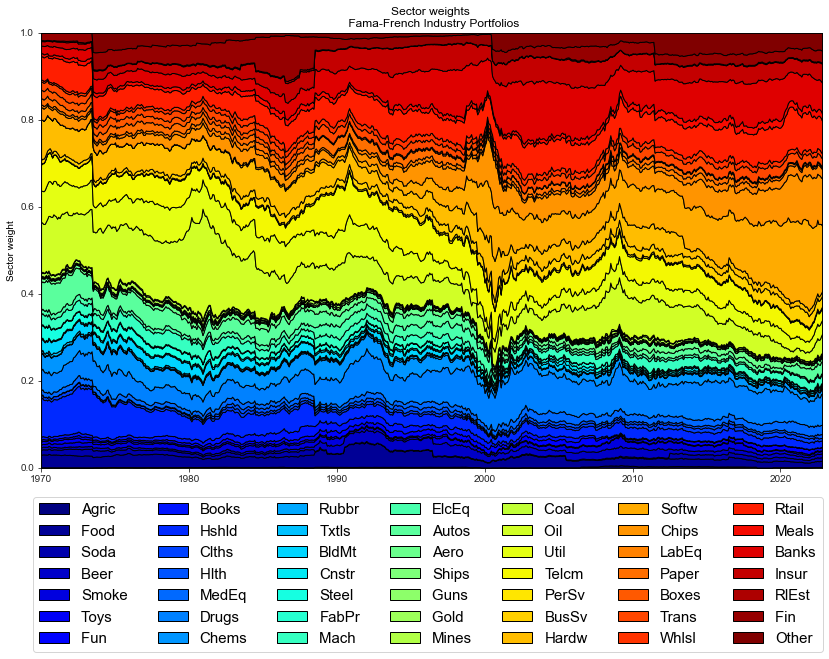

In [7]:
fig, ax = plt.subplots(figsize=(14, 8))

ax.stackplot(df_weights.index.to_timestamp(),
              df_weights.values.T,
              edgecolor="black",
              labels=df_weights.columns,
              colors=ind_colors);

ax.set_ylabel('Sector weight')
ax.set_title("Sector weights \n Fama-French Industry Portfolios");
ax.legend(ncol=7, bbox_to_anchor=(1.01, -0.05));

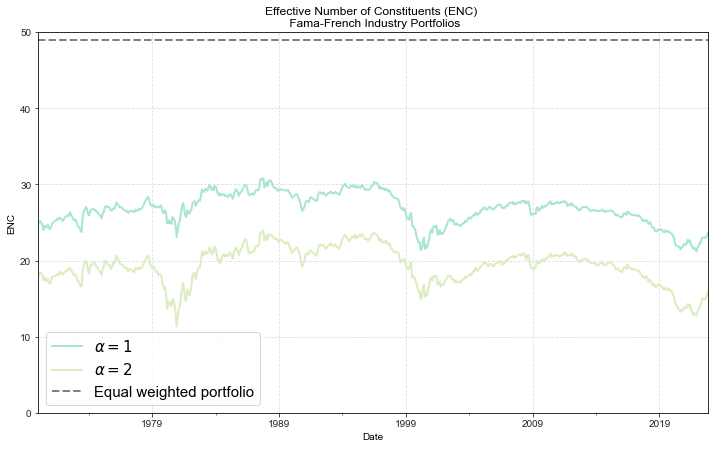

In [8]:
"""
Calculate Effective Number of Constituents (ENC) based on market capitialization
"""

df_enc1 = df_weights.apply(dm.calculate_enc, axis=1)
df_enc2 = df_weights.apply(dm.calculate_enc, axis=1, args=(2,))

fig, ax = plt.subplots(figsize=(12, 7))

df_enc1.plot(ax=ax, label="$\\alpha=1$")
df_enc2.plot(ax=ax, label="$\\alpha=2$")

ax.axhline(49, color='gray', linestyle='--', label="Equal weighted portfolio")
ax.set_ylim([0.0, 50.0])

ax.set_ylabel("ENC")
ax.set_title("Effective Number of Constituents (ENC) \n Fama-French Industry Portfolios")

ax.legend();

## Relative risk contributions

I choose an estimation horizon of one week since it provides a good trade off between the number of independent observations and the homogeneity of the data. 

Furthermore, I choose to using Exponential Weighted Moving Average (EWMA) filter to estimate the covariance matrix. I apply a window of 5 years of weekly observations and a half-life of 104 weeks (2 years).  

I use the "Average Value weighted Returns", but you can also choose to use the "Average Equal Weighted Returns". 

To perform the analysis, I can use `calculate_exponential_decay_probabilities` to calculate exponential probabilities. Given the probabilities, I can use `calculate_cov_mat` to calculate the covariance matrix. To calculate the risk contributions, I use `calculate_risk_contributions_std`. All functions are imported in the begining of the notebook. 

In [9]:
ff_daily_dict['DESCR']

'49 Industry Portfolios Daily\n----------------------------\n\nThis file was created by CMPT_IND_RETS_DAILY using the 202211 CRSP database. It contains value- and equal-weighted returns for 49 industry portfolios. The portfolios are constructed at the end of June. Missing data are indicated by -99.99 or -999. Copyright 2022 Kenneth R. French\n\n  0 : Average Value Weighted Returns -- Daily (13348 rows x 49 cols)\n  1 : Average Equal Weighted Returns -- Daily (13348 rows x 49 cols)'

In [10]:
"""
Calculate daily total return index
"""

ff_daily_ret = ff_daily_dict[0] / 100 # daily ret trans
ff_daily_prices = (1+ff_daily_ret).cumprod()

"""
Calculate weekly prices and return index
"""

ff_weekly_prices = ff_daily_prices.resample('W-WED').last()  # W-WED
ff_weekly_ret = ff_weekly_prices / ff_weekly_prices.shift(1) - 1
ff_weekly_ret.iloc[0, :] = ff_weekly_prices.iloc[0, :] - 1

In [11]:
"""
Initialize values
"""

# number of periods
num_periods = len(ff_weekly_ret)

# number of factors
num_assets = ff_weekly_ret.shape[1]

# window size 
window_size =  52 * 5 # 5 years of weekly observations 

# effective number of periods
eff_num_periods = num_periods - window_size

# half-life
half_life = 104

# time points
time_points = np.arange(1, window_size + 1)

# exponential probabilities 
exp_probs = calculate_exponential_decay_probabilities(window_size, time_points, half_life)

# equally weighted portfolio
eq_weigts = np.repeat(1.0 / num_assets, num_assets)

In [12]:
rel_risk_contribs = np.zeros((eff_num_periods, num_assets))

"""
Perform calculations
"""

for t in range(eff_num_periods):
    
    # covariance matrix
    cov_mat = calculate_cov_mat(ff_weekly_ret.iloc[t: window_size + t, :].values, probs=exp_probs)
    
    # calculate relative risk constribution 
    rel_risk_contribs[t, :] = rb.calculate_risk_contributions_std(eq_weigts, cov_mat, scale=True)

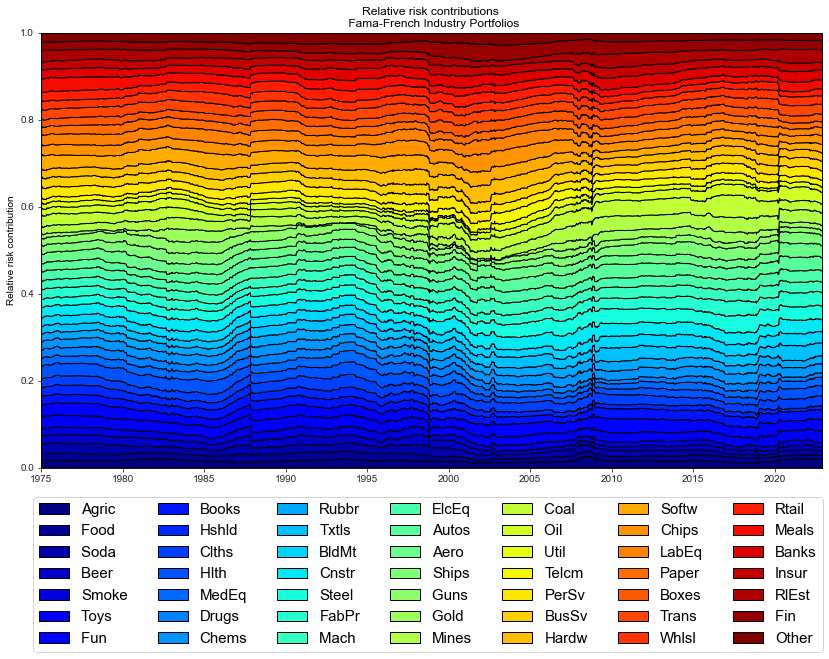

In [13]:
fig, ax = plt.subplots(figsize=(14, 8))

ax.stackplot(ff_weekly_ret.index[window_size:],
              rel_risk_contribs.T,
              edgecolor="black",
              labels=df_weights.columns,
              colors=ind_colors);

ax.set_ylabel('Relative risk contribution')
ax.set_title("Relative risk contributions \n Fama-French Industry Portfolios");
ax.legend(ncol=7, bbox_to_anchor=(1.01, -0.05));

## Diversification ratio

In this problem, we need to define the diversification ratio as a function. 

One important insight is that the diversification ratio is closely linked to the average correlation between the assets. Thus, when the average correlation increases, the CC-ratio decreases.

In [14]:
"""
Define function to calculate the diversification ratio of Yves Choueifaty and Yves Coignard (2008)
"""


def calculate_cc_ratio(weights: np.ndarray, cov_mat: np.ndarray):

    """
    Calculates the diversification ratio of Chouefaty and Coignard (2008)

    .. math::

        \\begin{equation}
            \\text{GLR}(w, \\Sigma) = \\frac{\\sum_{i=1}^N w_i \\sigma_i}{\\sqrt{w^{\\top} \\Sigma w}}
        \\end{equation}

    Parameters
    ----------
    weights:
        Portfolio weights.
    cov_mat:
        Covariance matrix.
        
    Returns
    -------
    float
        Diversification ratio.
    """

    port_std = rm.calculate_portfolio_std(weights=weights, cov_mat=cov_mat)

    vol_vec = np.sqrt(np.diag(cov_mat))
    avg_std = np.inner(weights, vol_vec)

    return avg_std / port_std

In [15]:
cc_ratios = np.zeros(eff_num_periods)
avg_corr = np.zeros(eff_num_periods)

upper_tri_idx = np.triu_indices(num_assets)

"""
Perform calculations
"""

for t in range(eff_num_periods):
    
    # covariance matrix
    cov_mat = calculate_cov_mat(ff_weekly_ret.iloc[t: window_size + t, :].values, probs=exp_probs)
    
    # average correlation
    avg_corr[t] = cov_to_corr_matrix(cov_mat)[upper_tri_idx].flatten().mean()
    
    # calculate relative risk constribution 
    cc_ratios[t] = calculate_cc_ratio(eq_weigts, cov_mat)

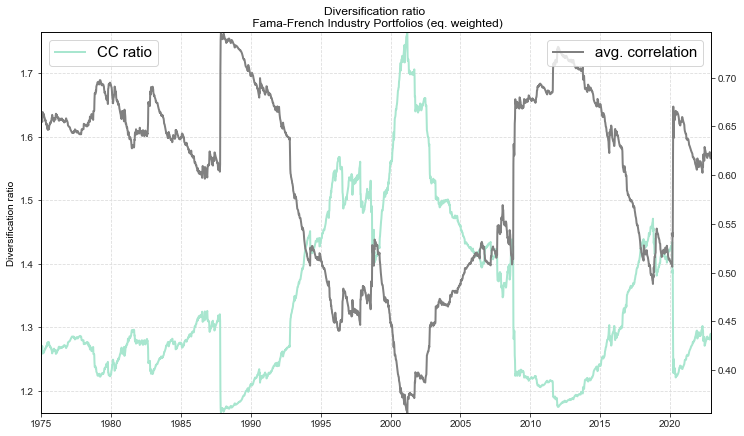

In [16]:
fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(ff_weekly_ret.index[window_size:], cc_ratios, label="CC ratio")
ax.set_ylabel("Diversification ratio")
ax.set_title("Diversification ratio \n Fama-French Industry Portfolios (eq. weighted)");
ax.legend(loc='upper left')
ax_new = ax.twinx()

ax_new.plot(ff_weekly_ret.index[window_size:], avg_corr, label="avg. correlation", color="gray")
ax_new.legend(loc='upper right')
ax_new.grid(None)

## Most diversified and minimum variance portfolios

We generally find that the most diversified portfolios contain positive allocation for more sectors. Minimum variance is not diversified compared to equally weighted portfolio.

In [17]:
def calculate_most_diversified_portfolio(cov_mat: np.ndarray, init_weights=None) -> np.ndarray:
    
    # define intial values
    n = cov_mat.shape[0]
    if init_weights is None:
        init_weights = np.repeat(1.0 / n, n)
    
    # define sum to one constraint
    eq_constraint = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    
    # perform optimization
    res = optimize.minimize(lambda x: -calculate_cc_ratio(x, cov_mat), init_weights,
                            constraints=[eq_constraint,], bounds=[(0, 1)]*n)
    
    return res.x

In [18]:
def calculate_min_var_portfolio(cov_mat: np.ndarray, init_weights=None) -> np.ndarray:
    
    # define intial values
    n = cov_mat.shape[0]
    if init_weights is None:
        init_weights = np.repeat(1.0 / n, n)
    
    # define sum to one constraint
    eq_constraint = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    
    # perform optimization
    res = optimize.minimize(lambda x: rm.calculate_portfolio_variance(x, cov_mat)*100*100,
                            init_weights,
                            constraints=[eq_constraint,],
                            bounds=[(0, 1)]*n)
    
    return res.x

In [19]:
most_div_port_weights = np.zeros((eff_num_periods, num_assets))
min_var_port_weights = np.zeros((eff_num_periods, num_assets))

most_div_port_cc = np.zeros(eff_num_periods)
min_var_port_cc = np.zeros(eff_num_periods)

"""
Perform calculations
"""

for t in range(eff_num_periods):
    
    # covariance matrix
    cov_mat = calculate_cov_mat(ff_weekly_ret.iloc[t: window_size + t, :].values, probs=exp_probs)
    
    # most diversified
    most_div_port_weights[t, :] = calculate_most_diversified_portfolio(cov_mat)
    most_div_port_cc[t] = calculate_cc_ratio(most_div_port_weights[t, :], cov_mat)
    
    # mnimum variance
    min_var_port_weights[t, :] = calculate_min_var_portfolio(cov_mat)
    min_var_port_cc[t] = calculate_cc_ratio(min_var_port_weights[t, :], cov_mat)

In [20]:
# store in data-frames
df_most_div_port_weights = pd.DataFrame(data=most_div_port_weights,
                                        index=ff_weekly_ret[window_size:].index,
                                        columns=ff_weekly_ret.columns)

df_min_var_port_weights = pd.DataFrame(data=min_var_port_weights,
                                        index=ff_weekly_ret[window_size:].index,
                                        columns=ff_weekly_ret.columns)

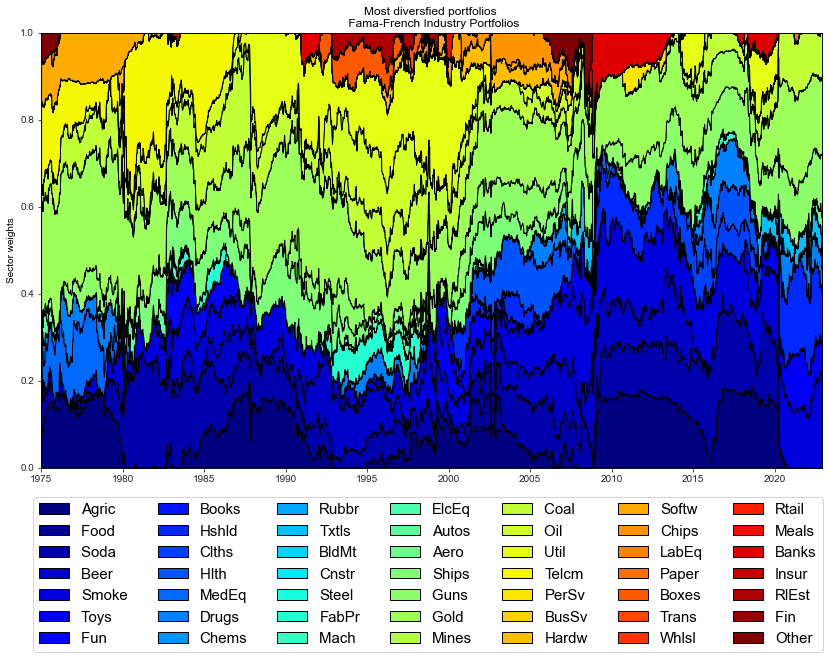

In [21]:
fig, ax = plt.subplots(figsize=(14, 8))

ax.stackplot(ff_weekly_ret.index[window_size:],
              most_div_port_weights.T,
              edgecolor="black",
              labels=df_weights.columns,
              colors=ind_colors);

ax.set_ylabel('Sector weights')
ax.set_title("Most diversfied portfolios \n Fama-French Industry Portfolios");
ax.legend(ncol=7, bbox_to_anchor=(1.01, -0.05));

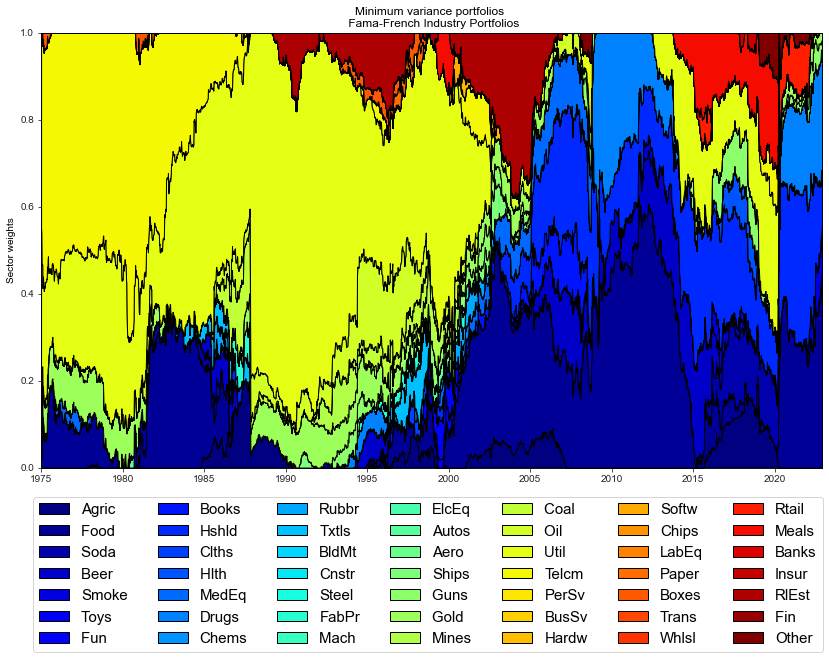

In [22]:
fig, ax = plt.subplots(figsize=(14, 8))

ax.stackplot(ff_weekly_ret.index[window_size:],
              min_var_port_weights.T,
              edgecolor="black",
              labels=df_weights.columns,
              colors=ind_colors);

ax.set_ylabel('Sector weights')
ax.set_title("Minimum variance portfolios \n Fama-French Industry Portfolios");
ax.legend(ncol=7, bbox_to_anchor=(1.01, -0.05));

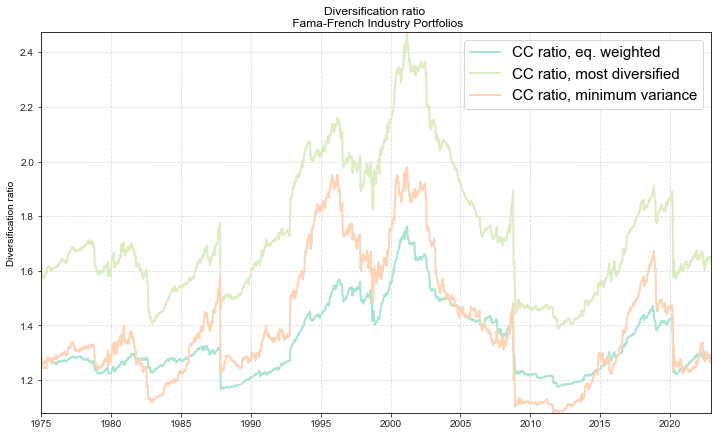

In [23]:
fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(ff_weekly_ret.index[window_size:], cc_ratios, label="CC ratio, eq. weighted")
ax.plot(ff_weekly_ret.index[window_size:], most_div_port_cc, label="CC ratio, most diversified")
ax.plot(ff_weekly_ret.index[window_size:], min_var_port_cc, label="CC ratio, minimum variance")
ax.set_ylabel("Diversification ratio")
ax.set_title("Diversification ratio \n Fama-French Industry Portfolios");
ax.legend();

In [24]:
eff_cons_most_div = df_most_div_port_weights.apply(dm.calculate_enc, axis=1)
eff_cons_min_var = df_min_var_port_weights.apply(dm.calculate_enc, axis=1)

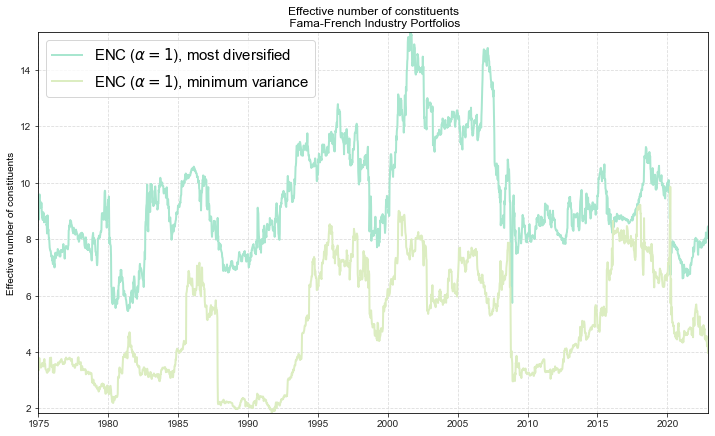

In [25]:
fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(ff_weekly_ret.index[window_size:], eff_cons_most_div, label="ENC ($\\alpha=1$), most diversified")
ax.plot(ff_weekly_ret.index[window_size:], eff_cons_min_var, label="ENC ($\\alpha=1$), minimum variance")
ax.set_ylabel("Effective number of constituents")
ax.set_title("Effective number of constituents\n Fama-French Industry Portfolios");
ax.legend();

### Evaluating strategies

In [26]:
df_port_ret = pd.DataFrame(index=ff_weekly_ret.index[window_size:])

# weekly return
df_port_ret['min-var'] = (ff_weekly_ret[window_size:] * df_min_var_port_weights).sum(axis=1)
df_port_ret['most-div'] = (ff_weekly_ret[window_size:] * df_most_div_port_weights).sum(axis=1)
df_port_ret['eq-weight'] = (ff_weekly_ret[window_size:] @ eq_weigts)

# total return index
df_port_tri = (1 + df_port_ret).cumprod(axis=0)

In [28]:
(1 + df_port_ret).prod(axis=0)

min-var      253.152395
most-div     312.400518
eq-weight    415.294937
dtype: float64

<AxesSubplot:xlabel='Date'>

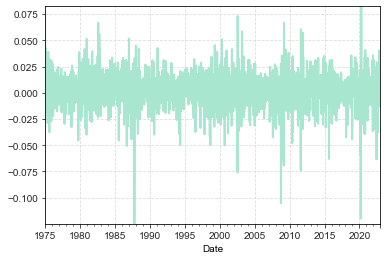

In [30]:
((ff_weekly_ret[window_size:] * df_min_var_port_weights).sum(axis=1)).plot()

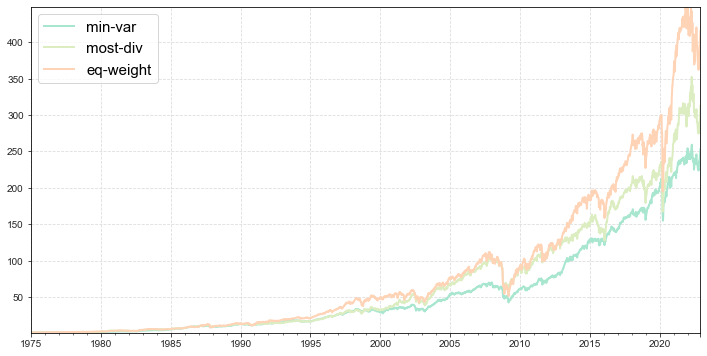

In [33]:
df_port_tri.plot(xlabel="", figsize=(12, 6));

In [34]:
mean_return = df_port_ret.mean(axis=0)
mean_return

min-var      0.002345
most-div     0.002526
eq-weight    0.002697
dtype: float64

In [35]:
std_return = df_port_ret.std(axis=0)
std_return

min-var      0.016043
most-div     0.021201
eq-weight    0.023671
dtype: float64

In [36]:
ir_ratio = mean_return / std_return
ir_ratio

min-var      0.146154
most-div     0.119122
eq-weight    0.113941
dtype: float64

In [37]:
df_adj_min_var_port_weights = (1 + ff_weekly_ret[window_size:]) * df_min_var_port_weights
df_adj_min_var_port_weights = df_adj_min_var_port_weights.divide(1+df_port_ret['min-var'].values, axis=0)
df_w_diff_min_var = (df_adj_min_var_port_weights.shift(1) - df_min_var_port_weights).dropna()

In [38]:
np.mean(np.linalg.norm(df_w_diff_min_var, axis=1, ord=1)) * 100

4.179954767247129

In [39]:
df_adj_most_div_port_weights = (1 + ff_weekly_ret[window_size:]) * df_most_div_port_weights
df_adj_most_div_port_weights = df_adj_most_div_port_weights.divide(1+df_port_ret['most-div'].values, axis=0)
df_w_diff_most_div = (df_adj_most_div_port_weights.shift(1) - df_most_div_port_weights).dropna()

In [40]:
np.mean(np.linalg.norm(df_w_diff_most_div, axis=1, ord=1)) * 100

5.300233024453176

In [41]:
df_adj_eq_port_weights = (1 + ff_weekly_ret[window_size:]).multiply(eq_weigts, axis=1)
df_adj_eq_port_weights = df_adj_eq_port_weights.divide(1+df_port_ret['eq-weight'].values, axis=0)
df_w_diff_eq = (df_adj_eq_port_weights.shift(1) - eq_weigts).dropna()

In [42]:
np.mean(np.linalg.norm(df_w_diff_eq, axis=1, ord=1)) * 100

1.491564260871125

## Factor exposure

In [43]:
ff_factors_daily_dict = FamaFrenchReader('F-F_Research_Data_Factors_daily', start='1970-01-01').read()

In [44]:
ff_factors_daily_dict['DESCR']

'F-F Research Data Factors daily\n-------------------------------\n\nThis file was created by CMPT_ME_BEME_RETS_DAILY using the 202211 CRSP database. The Tbill return is the simple daily rate that, over the number of trading days in the month, compounds to 1-month TBill rate from Ibbotson and Associates Inc. Copyright 2022 Kenneth R. French\n\n  0 : (13348 rows x 4 cols)'

In [45]:
ff_factors_daily_dict[0]

,Mkt-RF,SMB,HML,RF
Date,,,,
1970-01-02,1.18,1.29,1.01,0.029
1970-01-05,0.59,0.67,0.72,0.029
1970-01-06,-0.74,0.10,0.21,0.029
1970-01-07,-0.15,0.40,-0.33,0.029
1970-01-08,0.04,0.18,-0.17,0.029
...,...,...,...,...
2022-11-23,0.63,0.02,-0.94,0.014
2022-11-25,-0.02,0.22,0.44,0.014
2022-11-28,-1.55,-0.40,-0.20,0.014


In [46]:
"""
Calculate daily total return index
"""

ff_factors_daily_ret = ff_factors_daily_dict[0] / 100 # daily ret trans
ff_factors_daily_prices = (1+ff_factors_daily_ret).cumprod()

"""
Calculate weekly prices and return index
"""

ff_factors_weekly_prices = ff_factors_daily_prices.resample('W-WED').last()
ff_factors_weekly_ret = ff_factors_weekly_prices / ff_factors_weekly_prices.shift(1) - 1
ff_factors_weekly_ret.iloc[0, :] = ff_factors_weekly_prices.iloc[0, :] - 1

<AxesSubplot:xlabel='Date'>

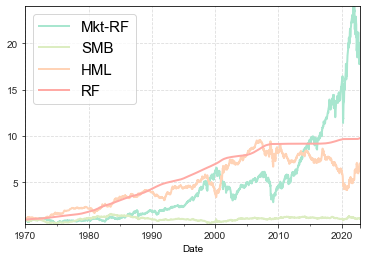

In [47]:
ff_factors_weekly_prices.plot();

# Problem 2: Optimal portfolios

In [48]:
asset_names = ["Government bonds", "Investment-grade bonds", "High-yield bonds",
               "Emerging markets gov. bonds", "Equities (developed markets)",
               "Equities (Emerging markets)", "Private equity", "Infrastructure",
               "Real Estate", "Hedgefunds"]

corr_mat = np.array([[1.00, 0.60, 0.10, 0.30, -0.10, -0.10, -0.20, -0.10, -0.10, -0.10],
                     [0.60, 1.00, 0.60, 0.60, 0.20, 0.20, 0.20, 0.10, 0.10, 0.30],
                     [0.10, 0.60, 1.00, 0.70, 0.70, 0.60, 0.60, 0.40, 0.30, 0.70],
                     [0.30, 0.60, 0.70, 1.00, 0.50, 0.60, 0.40, 0.20, 0.20, 0.50],
                     [-0.10, 0.20, 0.70, 0.50, 1.00, 0.70, 0.80, 0.40, 0.40, 0.80],
                     [-0.10, 0.20, 0.60, 0.60, 0.70, 1.00, 0.70, 0.40, 0.40, 0.70],
                     [-0.20, 0.20, 0.60, 0.40, 0.80, 0.70, 1.00, 0.40, 0.40, 0.70],
                     [-0.10, 0.10, 0.40, 0.20, 0.40, 0.40, 0.40, 1.00, 0.30, 0.40],
                     [-0.10, 0.10, 0.30, 0.20, 0.40, 0.40, 0.40, 0.30, 1.00, 0.40],
                     [-0.10, 0.30, 0.70, 0.50, 0.80, 0.70, 0.70, 0.40, 0.40, 1.00]])

vols = np.array([3.7, 5.5, 11.9, 10.7, 15.3, 21.7, 20.4, 14.0, 10.8, 9.4]) / 100.0

cov_mat = corr_to_cov_matrix(corr_mat=corr_mat, vols=vols)

mu = np.array([1.9, 2.2, 4.9, 4.3, 6.1, 8.3, 10.2, 5.6, 4.1, 3.8]) / 100 - 0.5 * vols**2 

# initial wealth
w0 = 5e6

# number of assets 
num_assets = len(mu)

In [49]:
cov_to_corr_matrix(cov_mat)

array([[ 1. ,  0.6,  0.1,  0.3, -0.1, -0.1, -0.2, -0.1, -0.1, -0.1],
       [ 0.6,  1. ,  0.6,  0.6,  0.2,  0.2,  0.2,  0.1,  0.1,  0.3],
       [ 0.1,  0.6,  1. ,  0.7,  0.7,  0.6,  0.6,  0.4,  0.3,  0.7],
       [ 0.3,  0.6,  0.7,  1. ,  0.5,  0.6,  0.4,  0.2,  0.2,  0.5],
       [-0.1,  0.2,  0.7,  0.5,  1. ,  0.7,  0.8,  0.4,  0.4,  0.8],
       [-0.1,  0.2,  0.6,  0.6,  0.7,  1. ,  0.7,  0.4,  0.4,  0.7],
       [-0.2,  0.2,  0.6,  0.4,  0.8,  0.7,  1. ,  0.4,  0.4,  0.7],
       [-0.1,  0.1,  0.4,  0.2,  0.4,  0.4,  0.4,  1. ,  0.3,  0.4],
       [-0.1,  0.1,  0.3,  0.2,  0.4,  0.4,  0.4,  0.3,  1. ,  0.4],
       [-0.1,  0.3,  0.7,  0.5,  0.8,  0.7,  0.7,  0.4,  0.4,  1. ]])

## Distribution of prices and wealth at $t=5$

We have assumed that the log-returns follow a multivariate normal distribution

$$
\mathbf{r}_{t+ 1, 1} = \log \frac{\mathbf{P}_{t+1}}{\mathbf{P}_t} \sim N(\boldsymbol{\mu}, \boldsymbol{\Sigma})
$$

Since log returns aggregates across time, we have that 

$$
\mathbf{r}_{5, 5} = \log \frac{\mathbf{P}_{5}}{\mathbf{P}_0} = \log \mathbf{P}_{5}  \sim N(5\boldsymbol{\mu}, 5\boldsymbol{\Sigma})
$$

Thus, $\mathbf{P}_{5} = e^{\mathbf{r}_{5, 5}}$. Since $e^{\mathbf{r}_{5, 5}}$ follows a multivariate log-normal distribution (see [here](https://www.casact.org/sites/default/files/database/forum_15spforum_halliwell.pdf))

$$
\text{E}[e^{\mathbf{r}_{5, 5}}] = \text{E}[\mathbf{P}_{5}] = e^{5\mu  + \frac{1}{2}\text{diag}(5\boldsymbol{\Sigma})}
$$

and 

$$
\text{Cov}[e^{\mathbf{r}_{5, 5}}] =  \text{Cov}[\mathbf{P}_{5}] =  \text{E}[e^{\mathbf{r}_{5, 5}}] \text{E}[e^{\mathbf{r}_{5, 5}}]^\top \odot \left(e^{5\boldsymbol{\Sigma}} - \mathbf{1} \right)
$$

So, clearly $\mathbf{P}_5$ follows a multivariate log-normal distribution. 

The final wealth can be written as 

$$
W_5 = \boldsymbol{\alpha}^\top \mathbf{P}_5
$$

We do not know the distribution of the linear combination of log-normal random variables! However, we know that the expected value and variance is

$$
\text{E}[W_5] = \boldsymbol{\alpha}^\top \text{E}[\mathbf{P}_{5}]
$$

and 

$$
\text{Var}[W_5] = \boldsymbol{\alpha}^\top  \text{Cov}[\mathbf{P}_{5}] \boldsymbol{\alpha}
$$

In the following mean-variance optimization, we can perform our analysis without knowledge of the exact distribution. To calculate expectations of the non-linear satisfaction, we may use approximations or simulations. 

## Plot simulated distribution 

In [50]:
alpha_init = np.repeat(500000.0, num_assets)
time_step = 1.0 / 12.0
num_periods = 60
time_points = np.arange(0, 5.0 + time_step, time_step)
num_sim = int(1e4)
sim_prices = np.exp(np.cumsum(np.random.multivariate_normal(mu * time_step, cov_mat * time_step,
                                                            size=(num_sim, num_periods)), axis=1))

sim_wealth = np.c_[np.ones(num_sim) * w0, sim_prices @ alpha_init]

In [51]:
mu * 5

array([0.0915775, 0.1024375, 0.2095975, 0.1863775, 0.2464775, 0.2972775,
       0.40596  , 0.231    , 0.17584  , 0.16791  ])

In [52]:
sim_prices[:, -1, :].mean(axis=0)

array([1.09928474, 1.11647158, 1.27722314, 1.23614804, 1.35656314,
       1.50224069, 1.66487522, 1.32292263, 1.22616395, 1.2074325 ])

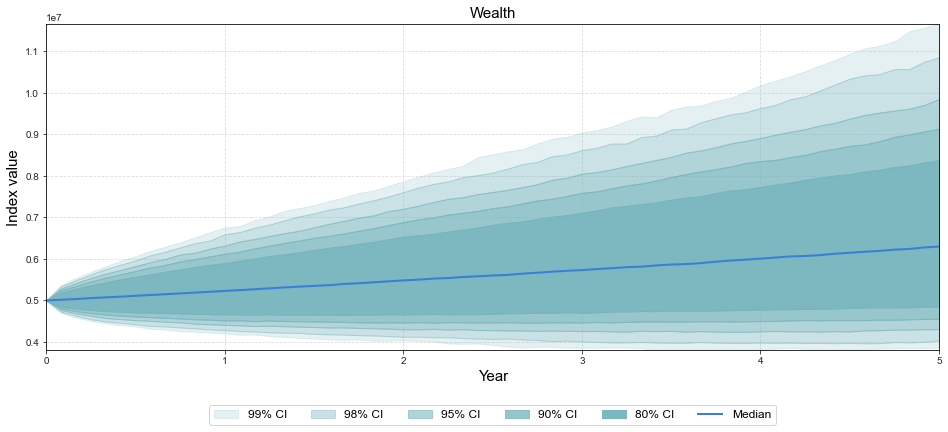

In [53]:
# calculate percentiles
percentiles_wealth = np.percentile(sim_wealth, [0.5, 1.0, 2.5, 5, 10, 50, 90, 95, 97.5, 99.0, 99.5],
                                         axis=0)

"""
Plot fan chart
"""

fig, ax = plt.subplots(figsize=(16, 6))

fan_chart(time_points,
          percentiles_wealth,
          color=default_colors['cyan'],
          color_median=default_colors['dark_blue'],
          labels=['99% CI', '98% CI', '95% CI', '90% CI', '80% CI', 'Median'],
          ax=ax)

ax.set_xlabel("Year", size=15)
ax.set_ylabel("Index value", size=15)
ax.set_title("Wealth", size=15)
#ax.set_ylim([0.5, 3.0])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=6, fontsize=12);

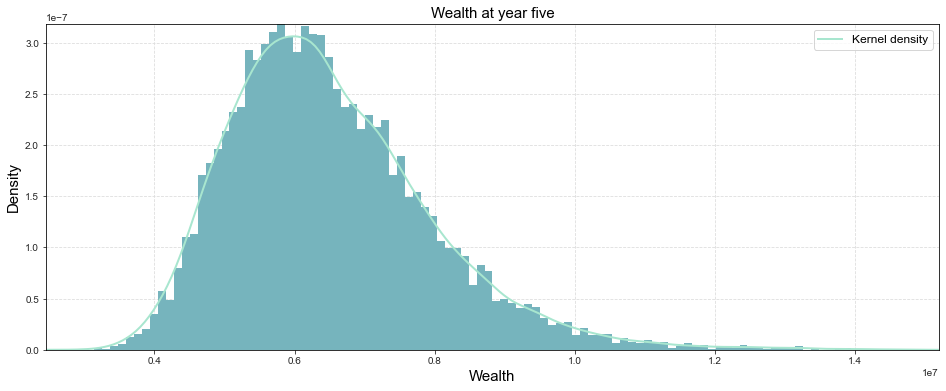

In [54]:
"""
Plot density of portfolio wealth at year 5
"""

fig, ax = plt.subplots(figsize=(16, 6))

ax.hist(sim_wealth[:, -1],
        color=default_colors['cyan'],
        bins=100, 
        density=True)

sns.kdeplot(sim_wealth[:, -1], ax=ax, label="Kernel density")

ax.set_xlabel("Wealth", size=15)
ax.set_ylabel("Density", size=15)
ax.set_title("Wealth at year five", size=15)
#ax.set_ylim([0.5, 3.0])
ax.legend(fontsize=12);

## Transaction costs

In [55]:
def calculate_transaction_costs(alpha: np.ndarray, alpha_init: np.ndarray, k: np.ndarray, d: np.ndarray) -> float:
    
    """
    Calculates quadratic transaction costs
    
    Paramters
    ---------
    alpha: 
        Portfolio allocations.
    alpha_init: 
        Initial portfolio allocations. 
    k: 
        Linear transaction costs.
    d: 
        Quadratic transaction costs. 
    
    Returns
    -------
    float 
        Total transaction costs. 
    
    """
    
    diff = alpha - alpha_init
    
    return  (diff > 0) * diff * k - (diff < 0) * diff * k + diff**2 * d

In [56]:
alpha_vals = np.linspace(0, 5000000, 100)
alpha_init = 500000

#transaction_costs = calculate_transaction_costs(alpha_vals, alpha_init, k=0.02, d=0.00000001)
transaction_costs = calculate_transaction_costs(alpha_vals, alpha_init, k=0.02, d=0.0000)

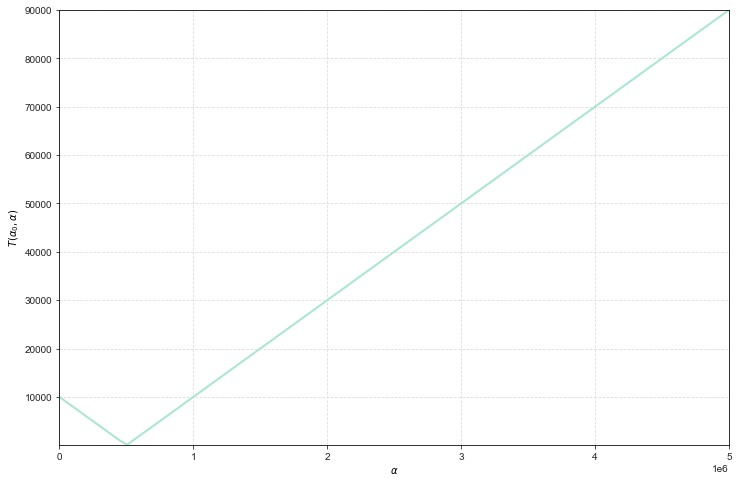

In [57]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(alpha_vals, transaction_costs)

ax.set_xlabel('$\\alpha$')
ax.set_ylabel('$T(\\alpha_0, \\alpha)$');

## Solving the portfolio optimization problem

The optimization problem reads

$$
\arg \max_\boldsymbol{\alpha}  \text{E}[W_5(\boldsymbol{\alpha})]
$$

subject to 

$$
\text{Sd}[W_5(\boldsymbol{\alpha})] =  v
$$

and 

$$
\boldsymbol{\alpha} \geq \mathbf{0}
$$

and 

$$
W_0 - \mathbf{k}^\top \vert \boldsymbol{\alpha}_0 - \boldsymbol{\alpha} \vert = \boldsymbol{\alpha}^\top \mathbf{P}_0
$$

__Note__: We can transform the problem into one, where we optimize over the relative weights. Thus, 

$$
\arg \max_\boldsymbol{\mathbf{w}}  \text{E}[\mathbf{w} \mathbf{P}_5]
$$

subject to 

$$
\text{Sd}[\mathbf{w} \mathbf{P}_5] =  \tilde{v}
$$

and 

$$
\boldsymbol{\mathbf{w}} \geq \mathbf{0}
$$

and 

$$
1 - \mathbf{k}^\top \vert \mathbf{w}_0 - \mathbf{w} \vert = \mathbf{w}^\top \mathbf{P}_0
$$

### Relevant variance targets

First, we need to figure out relevant variance targets. To obtain the smallest variance target, we can solve the minimum-variance problem. 

In [58]:
mu_l = calculate_log_norm_mean(5*mu, 5*cov_mat)
cov_mat_l = calculate_log_norm_cov_mat(5*mu, 5*cov_mat)
alpha_init = np.repeat(500000.0, num_assets)

In [59]:
mu_l

array([1.09965886, 1.11627807, 1.27762131, 1.2398619 , 1.356625  ,
       1.51437074, 1.66529119, 1.32312981, 1.22752506, 1.2092496 ])

In [60]:
def calculate_wealth(alpha: np.ndarray, mu: np.ndarray):
    
    return alpha @ mu

def calculate_neg_wealth(alpha: np.ndarray, mu: np.ndarray):
    
    return -calculate_wealth(alpha, mu) * 1e6

def calculate_portfolio_variance(alpha: np.ndarray, cov_mat: np.ndarray) -> float: 
    
    """
    Calculates the portfolio variance. 
    """
    
    return alpha @ cov_mat @ alpha


def calculate_portfolio_std(alpha: np.ndarray, cov_mat: np.ndarray) -> float: 
    
    """
    Calculates the portfolio std. 
    """
    
    return np.sqrt(alpha @ cov_mat @ alpha)


In [61]:
def calculate_total_transaction_costs(alpha: np.ndarray, alpha_init: np.ndarray,
                                      k: np.ndarray, d: np.ndarray) -> float:
    
    """
    Calculates total quadratic transaction costs
    
    Paramters
    ---------
    alpha: 
        Portfolio allocations.
    alpha_init: 
        Initial portfolio allocations. 
    k: 
        Linear transaction costs.
    d: 
        Quadratic transaction costs. 
    
    Returns
    -------
    float 
        Total transaction costs. 
    
    """
    
    diff = alpha - alpha_init
    
    return  np.sum((diff > 0) * diff * k - (diff < 0) * diff * k + diff**2 * d)

In [62]:
"""
Define budget constraint
"""

def calculate_budget_constraint(alpha, alpha0, k, d): 
    
    return (np.sum(alpha0) - calculate_total_transaction_costs(alpha, alpha0, k, d) - np.sum(alpha))

budget_constraint = {'type': 'eq',
                     'fun': lambda x: calculate_budget_constraint(x, alpha_init, k=0.02, d=0.0)}


In [63]:
res = optimize.minimize(calculate_portfolio_std,
                        x0=alpha_init,
                        args=(cov_mat_l,),
                        method='SLSQP',
                        constraints=[budget_constraint], 
                        options={'disp': True, 'maxiter': 5000},
                        bounds=[(0.0, w0)] * num_assets)
min_var_port = res.x

Optimization terminated successfully    (Exit mode 0)
            Current function value: 406449.01272712793
            Iterations: 371
            Function evaluations: 4399
            Gradient evaluations: 370


In [64]:
alpha_init

array([500000., 500000., 500000., 500000., 500000., 500000., 500000.,
       500000., 500000., 500000.])

### Perform mean-variance optimization

If we perform the optimization directly using alpha, then we may run into numerical problems. 

In [65]:
if False: 
    
    def calculate_std_target_constraint(alpha, cov_mat, target_std):
    
        return (target_std - calculate_portfolio_std(alpha, cov_mat)) * 1e6
    
    std_targets = np.linspace(410000, 3000000, 250)

    """
    Find optimal allocations
    """
    optimal_allocations = list()

    alpha_init_temp = min_var_port.copy()
    for v in std_targets: 

        std_target_constraint = {'type': 'eq',
                         'fun': lambda x: calculate_std_target_constraint(x, cov_mat_l, v)}

        res = optimize.minimize(calculate_neg_wealth,
                                x0=alpha_init,
                                args=(mu_l,),
                                method='SLSQP',
                                constraints=[budget_constraint, std_target_constraint], 
                                options={'disp': True,
                                         'ftol': 1e-16,
                                         'maxiter': 5000, 
                                         'eps': 1.5e-7},
                                bounds=[(0.0, w0)] * num_assets)

        optimal_allocations.append(res.x)

        alpha_init_temp = res.x

    optimal_allocations = np.array(optimal_allocations)


In [66]:
if False: 

    def calculate_wealth_constraint(alpha, mu, target_wealth):

        return (target_wealth - calculate_wealth(alpha, mu)) * 1e2

    wealth_targets = np.linspace(5500000, 8000000, 200)

    """
    Find optimal allocations
    """
    optimal_allocations = list()

    alpha_init_temp = min_var_port.copy()
    for m in wealth_targets: 

        wealth_target_constraint = {'type': 'eq',
                         'fun': lambda x: calculate_wealth_constraint(x, mu_l, m)}

        res = optimize.minimize(lambda x: calculate_portfolio_std(x, cov_mat_l),
                                x0=alpha_init,
                                method='SLSQP',
                                constraints=[budget_constraint, wealth_target_constraint], #budget_constraint, 
                                options={'disp': True,
                                         'ftol': 1e-16,
                                         'maxiter': 5000, 
                                         'eps': 1e-8},
                                bounds=[(0.0, w0)] * num_assets)

        optimal_allocations.append(res.x)

        alpha_init_temp = res.x

    optimal_allocations = np.array(optimal_allocations)


In [67]:
(sim_wealth[:, -1] / 5000000 ).mean()

1.300932562293046

In [68]:
(sim_wealth[:, -1] / 5000000 ).std()

0.28772552180328076

As written above, it will be possible to transform the optimization problem into one using the relative weights. This will be much easier to optimize. 

In [69]:
"""
Perform directly on relative weights
"""

init_w = np.repeat(1.0 / num_assets, num_assets)

if True:
    
    def calculate_std_target_constraint(alpha, cov_mat, target_std):
    
        return (target_std - calculate_portfolio_std(alpha, cov_mat)) * 1e6
    
    def calculate_neg_wealth(alpha: np.ndarray, mu: np.ndarray):
    
        return -calculate_wealth(alpha, mu) 
    
    def calculate_budget_constraint(alpha, alpha0, k, d): 
    
        return (1 - calculate_total_transaction_costs(alpha, alpha0, k, d) - np.sum(alpha))

    budget_constraint = {'type': 'eq',
                         'fun': lambda x: calculate_budget_constraint(x, init_w, k=0.02, d=0.0)}
    
    std_targets = np.linspace(0.105, 0.65, 250)

    """
    Find optimal allocations
    """
    optimal_allocations = list()

    w_init_temp = init_w
    for v in std_targets: 

        std_target_constraint = {'type': 'eq',
                         'fun': lambda x: calculate_std_target_constraint(x, cov_mat_l, v)}

        res = optimize.minimize(calculate_neg_wealth,
                                x0=w_init_temp,
                                args=(mu_l,),
                                method='SLSQP',
                                constraints=[budget_constraint, std_target_constraint], #budget_constraint, 
                                options={'disp': True,
                                         #'ftol': 1e-16,
                                         'maxiter': 5000}, 
                                         #'eps': 1.5e-7},
                                bounds=[(0.0, 1.0)] * num_assets)

        optimal_allocations.append(res.x)

        w_init_temp = res.x

    optimal_allocations = np.array(optimal_allocations) * w0

    

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.145890928477247
            Iterations: 657
            Function evaluations: 13155
            Gradient evaluations: 657
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.1487223201646521
            Iterations: 19
            Function evaluations: 218
            Gradient evaluations: 19
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.1514944945106436
            Iterations: 49
            Function evaluations: 644
            Gradient evaluations: 49
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.1542123729021283
            Iterations: 1110
            Function evaluations: 22979
            Gradient evaluations: 1110
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.1568809530569863
            Iterations: 41
      

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.2332530851379153
            Iterations: 62
            Function evaluations: 1098
            Gradient evaluations: 62
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.2351080371205991
            Iterations: 398
            Function evaluations: 8092
            Gradient evaluations: 398
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.236958259092699
            Iterations: 64
            Function evaluations: 1108
            Gradient evaluations: 64
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.2388039430565738
            Iterations: 76
            Function evaluations: 1185
            Gradient evaluations: 76
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.2406452669566894
            Iterations: 3810
        

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.3044781088220914
            Iterations: 753
            Function evaluations: 15568
            Gradient evaluations: 753
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.3062046576716557
            Iterations: 131
            Function evaluations: 2384
            Gradient evaluations: 131
Iteration limit reached    (Exit mode 9)
            Current function value: -1.3079298941318356
            Iterations: 5000
            Function evaluations: 104718
            Gradient evaluations: 5000
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.309653665872252
            Iterations: 50
            Function evaluations: 767
            Gradient evaluations: 50
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.3113722175909064
            Iterations: 65
            Fun

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.3696128983509641
            Iterations: 79
            Function evaluations: 1209
            Gradient evaluations: 79
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.371177513818456
            Iterations: 37
            Function evaluations: 560
            Gradient evaluations: 37
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.3727393947398525
            Iterations: 41
            Function evaluations: 571
            Gradient evaluations: 41
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.3742898448187215
            Iterations: 50
            Function evaluations: 685
            Gradient evaluations: 50
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.3758280539090078
            Iterations: 27
            Fun

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.4275435565689811
            Iterations: 2088
            Function evaluations: 43600
            Gradient evaluations: 2088
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.428978891996192
            Iterations: 40
            Function evaluations: 508
            Gradient evaluations: 40
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.430407185618228
            Iterations: 39
            Function evaluations: 526
            Gradient evaluations: 39
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.4318286129401439
            Iterations: 59
            Function evaluations: 972
            Gradient evaluations: 59
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.4332444000852762
            Iterations: 36
           

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.4836865324368573
            Iterations: 73
            Function evaluations: 1119
            Gradient evaluations: 73
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.4850055920790672
            Iterations: 62
            Function evaluations: 911
            Gradient evaluations: 62
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.4863230019447435
            Iterations: 37
            Function evaluations: 507
            Gradient evaluations: 37
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.487638787501146
            Iterations: 83
            Function evaluations: 1259
            Gradient evaluations: 83
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.4889529740134773
            Iterations: 34
            Fu

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.5352691716199456
            Iterations: 266
            Function evaluations: 5424
            Gradient evaluations: 266
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.5365285369752941
            Iterations: 20
            Function evaluations: 283
            Gradient evaluations: 20
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.5377868039861866
            Iterations: 76
            Function evaluations: 1343
            Gradient evaluations: 76
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.5390439867510568
            Iterations: 38
            Function evaluations: 674
            Gradient evaluations: 38
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.5403000990627624
            Iterations: 16
           

In [70]:
"""
Calculate relative weights
"""
mv_init = np.sum(optimal_allocations, axis=1)

optimal_relative_weights = (1 / mv_init)[:, None] * optimal_allocations


In [71]:
"""
Calculate port. wealth
"""

port_wealth = np.apply_along_axis(calculate_wealth, 1, optimal_allocations, mu_l)

In [72]:
"""
Calculate port. std
"""

port_std = np.apply_along_axis(calculate_portfolio_std, 1, optimal_allocations, cov_mat_l)

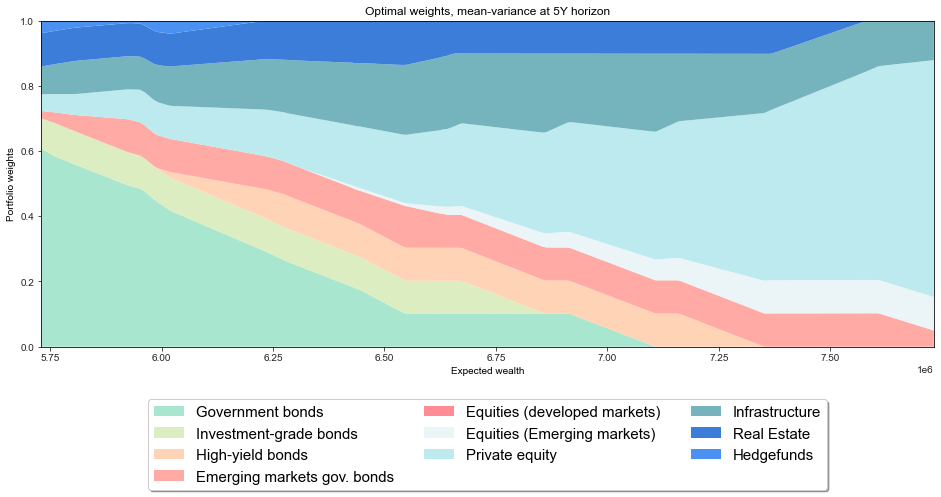

In [73]:
fig, ax = plt.subplots(figsize=(16, 6))

ax.stackplot(port_wealth, optimal_relative_weights.T, labels=asset_names);
ax.set_xlabel("Expected wealth")
ax.set_ylabel("Portfolio weights")
ax.set_title("Optimal weights, mean-variance at 5Y horizon")
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.3), fancybox=True, shadow=True, ncol=3);

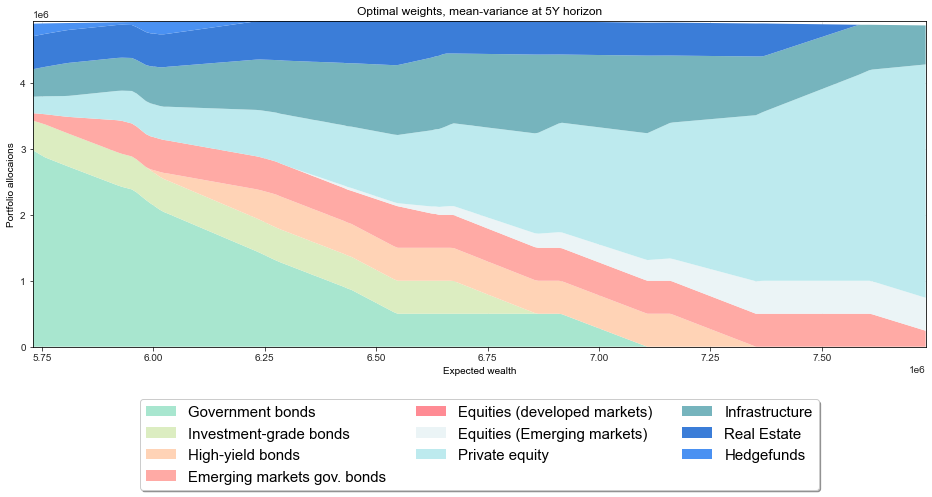

In [74]:
fig, ax = plt.subplots(figsize=(16, 6))

ax.stackplot(port_wealth, optimal_allocations.T, labels=asset_names);
ax.set_xlabel("Expected wealth")
ax.set_ylabel("Portfolio allocaions")
ax.set_title("Optimal weights, mean-variance at 5Y horizon")
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.3), fancybox=True, shadow=True, ncol=3);

## Relationship with investor's preference

The easiest way to calcuate the investor's satisfaction is to use simulations. Thus, we can calculate 

$$
\hat{S}(\boldsymbol{\alpha}) = \left( \gamma \frac{1}{J} \sum_{j=1}^J W_5(\boldsymbol{\alpha})^\gamma \right)^{1 / \gamma}
$$

where $J$ denotes the number of simulations. 

In [75]:
"""
Simulate data
"""

num_sim = int(1e6)
sim_prices = np.exp(np.random.multivariate_normal(mu*5, cov_mat*5, size=num_sim))

In [76]:
def calculate_power_utility(wealth, gamma): 
    
    """
    Calculates power utility. 
    """
    
    return 1 / gamma * wealth**gamma

def calculate_certainty_equivalent(alpha: np.ndarray, sim_prices: np.ndarray, gamma: float):
    
    """
    Calculates certainty equivalent for a portfolio for a given risk aversion. 
    
    The expecation is calculated using simulated prices. 
    """
    
    sim_wealth = sim_prices @ alpha
    
    utility = calculate_power_utility(sim_wealth, gamma)
    
    certainty_eq = np.mean(gamma * utility)**(1 / gamma)
    
    return certainty_eq

In [77]:
gamma = -9
satisfactions = np.apply_along_axis(calculate_certainty_equivalent, 1,
                                    optimal_allocations, sim_prices, gamma)

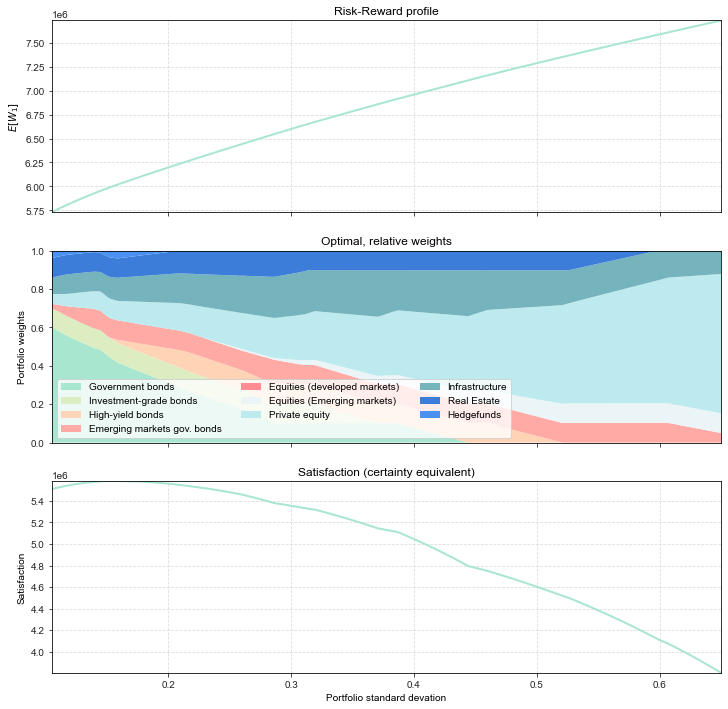

In [78]:
fig, ax = plt.subplots(3,1, figsize=(12, 12), sharex=True)

"""
Expected wealth
"""

ax[0].plot(std_targets, port_wealth)
ax[0].set_ylabel("$E[W_1]$")
ax[0].title.set_text("Risk-Reward profile")

"""
Relative weights
"""

ax[1].stackplot(std_targets, optimal_relative_weights.T, labels=asset_names);
ax[1].set_ylabel("Portfolio weights")
ax[1].set_title("Optimal, relative weights")
ax[1].legend(ncol=3, fontsize=10, loc="lower left");

"""
Satisfaction
"""
ax[2].plot(std_targets, satisfactions)
ax[2].set_ylabel("Satisfaction")
ax[2].set_xlabel("Portfolio standard devation")
ax[2].set_title("Satisfaction (certainty equivalent)");

In [79]:
"""
Portfolio with highest satisfaction
"""

idx = np.argmax(satisfactions)

opt_alloc = optimal_allocations[idx, :]
opt_alloc

array([2.22410097e+06, 4.99998896e+05, 7.58165556e-12, 5.00000141e+05,
       1.94504910e-11, 0.00000000e+00, 5.00000008e+05, 5.47440863e+05,
       4.99999989e+05, 1.56151304e+05])

In [80]:
satisfactions[idx]

5584522.210640157

Text(0.5, 0, 'Portfolio Wealth')

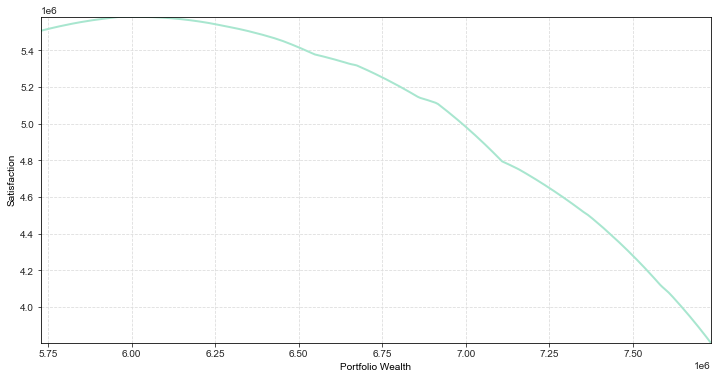

In [81]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(port_wealth, satisfactions)
ax.set_ylabel("Satisfaction")
ax.set_xlabel("Portfolio Wealth")
#ax.title.set_text("Risk-Reward profile")

## Alternative optimization utilizing the CVXOPT package

The `CVXOPT` package can deal with problems like

$$
\min \; (1 / 2) \mathbf{x}^\top \mathbf{P} \mathbf{x} + \mathbf{q}^\top \mathbf{x}
$$

subject to 

$$
\mathbf{G} \mathbf{x} <= \mathbf{h}
$$

and 

$$
\mathbf{A} \mathbf{x} = \mathbf{b}
$$

Our problem can be written as above since the mean-variance problem with budget constraint can be reformulated as 

$$
\min \; \frac{1}{2}\boldsymbol{\alpha}^\top \boldsymbol{\Sigma} \boldsymbol{\alpha}
$$

subject to 

$$
\mathbf{1}^\top \boldsymbol{\alpha} + \mathbf{k}^\top \Delta \boldsymbol{\alpha}_{+} - \mathbf{k}^\top \Delta \boldsymbol{\alpha}_{-} = W_0 
$$

and 

$$
\boldsymbol{\alpha} + \Delta \boldsymbol{\alpha}_{+} - \Delta \boldsymbol{\alpha}_{-} = \boldsymbol{\alpha}_0
$$

and

$$
\boldsymbol{\alpha}^\top \boldsymbol{\mu}  = \bar{\mu} 
$$

and

$$
\boldsymbol{\alpha}_{-} \leq 0, \boldsymbol{\alpha}_{+} \geq 0
$$

In [82]:
"""
Load relevant packages
"""

from math import sqrt
from cvxopt import matrix
from cvxopt.blas import dot
from cvxopt.solvers import qp, options

In [83]:
"""
Define minimization problem 
"""
n = num_assets
P = matrix(np.block([[cov_mat_l, np.zeros((n,n)), np.zeros((n,n))],
                     [np.zeros((n,n)), np.zeros((n,n)), np.zeros((n,n))],
                     [np.zeros((n,n)), np.zeros((n,n)), np.zeros((n,n))]]))

#q = matrix(np.r_[mu_l, np.zeros(n), np.zeros(n)])
q = matrix(np.r_[np.zeros(n), np.zeros(n), np.zeros(n)])

#G = matrix(np.block([[-np.eye(n), np.zeros((n,n)), np.zeros((n,n))],
#                     [np.zeros((n,n)), -np.eye(n), np.zeros((n,n))],
#                     [np.zeros((n,n)), np.zeros((n,n)), np.eye(n)]]))

G = matrix(np.r_[np.block([[-np.eye(n), np.zeros((n,n)), np.zeros((n,n))],
                     [np.zeros((n,n)), -np.eye(n), np.zeros((n,n))],
                     [np.zeros((n,n)), np.zeros((n,n)), np.eye(n)]]), 
                 np.block([[np.eye(n), np.zeros((n,n)), np.zeros((n,n))],
                     [np.zeros((n,n)), np.eye(n), np.zeros((n,n))],
                     [np.zeros((n,n)), np.zeros((n,n)), -np.eye(n)]])])

h = matrix(np.r_[np.zeros(3 * n), w0*np.ones(3 * n)])

#A = matrix(np.atleast_2d(np.r_[np.ones(n), 0.03*np.ones(n), -0.03*np.ones(n)]))

A = matrix(np.c_[np.r_[np.eye(n), np.eye(n), np.eye(n)],
                 np.r_[np.ones(n), 0.02*np.ones(n), -0.02*np.ones(n)],
                 np.r_[mu_l, np.zeros(n), np.zeros(n)]].T)

#b = matrix(np.array([500000 for i in range(10)] + [w0, 6000000]))

w_targets = np.linspace(5500000.0, 8000000, 200)

bs = [matrix(np.array([500000 for i in range(10)] + [w0, w_target])) for w_target in w_targets]

In [84]:
optimal_allocations = np.array([np.array(qp(P, q , G, h, A, b)['x']).flatten()[:10] for b in bs])

     pcost       dcost       gap    pres   dres
 0:  1.0850e+12 -2.4935e+14  3e+14  2e-15  3e-09
 1:  1.0443e+12 -8.3093e+12  9e+12  4e-16  3e-09
 2:  4.9882e+11 -1.5695e+12  2e+12  9e-16  9e-10
 3:  2.0189e+11 -1.9083e+11  4e+11  6e-16  6e-10
 4:  9.9314e+10  4.4833e+10  5e+10  2e-15  2e-10
 5:  8.2282e+10  7.3856e+10  8e+09  5e-16  1e-10
 6:  7.9719e+10  7.9113e+10  6e+08  3e-16  6e-11
 7:  7.9479e+10  7.9462e+10  2e+07  5e-16  6e-11
 8:  7.9473e+10  7.9473e+10  2e+05  9e-16  4e-11
 9:  7.9473e+10  7.9473e+10  2e+03  8e-16  5e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.1085e+12 -2.5055e+14  3e+14  2e-15  5e-09
 1:  1.0670e+12 -8.4565e+12  1e+13  3e-16  5e-09
 2:  5.1267e+11 -1.6011e+12  2e+12  4e-15  7e-10
 3:  2.0972e+11 -2.0014e+11  4e+11  1e-15  5e-10
 4:  1.0184e+11  4.4400e+10  6e+10  1e-15  2e-10
 5:  8.3629e+10  7.5574e+10  8e+09  8e-16  1e-10
 6:  8.0982e+10  8.0456e+10  5e+08  2e-16  6e-11
 7:  8.0798e+10  8.0788e+10  1e+07  3e-16  8e-1

 6:  1.2744e+11  1.2538e+11  2e+09  2e-16  2e-10
 7:  1.2692e+11  1.2686e+11  6e+07  3e-16  2e-10
 8:  1.2690e+11  1.2690e+11  9e+05  2e-16  2e-10
 9:  1.2690e+11  1.2690e+11  9e+03  1e-15  1e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.5249e+12 -2.6918e+14  3e+14  2e-15  6e-09
 1:  1.4683e+12 -1.1002e+13  1e+13  1e-15  6e-09
 2:  7.6072e+11 -2.5187e+12  3e+12  4e-15  1e-09
 3:  3.9560e+11 -3.9022e+11  8e+11  8e-16  8e-10
 4:  1.7878e+11  2.3462e+10  2e+11  2e-15  3e-10
 5:  1.3607e+11  1.1922e+11  2e+10  2e-15  9e-11
 6:  1.3208e+11  1.3023e+11  2e+09  2e-16  1e-10
 7:  1.3161e+11  1.3156e+11  5e+07  2e-16  2e-10
 8:  1.3159e+11  1.3159e+11  1e+06  2e-15  1e-10
 9:  1.3159e+11  1.3159e+11  1e+04  4e-15  1e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.5534e+12 -2.7032e+14  3e+14  2e-15  4e-09
 1:  1.4958e+12 -1.1176e+13  1e+13  5e-16  6e-09
 2:  7.7795e+11 -2.6294e+12  3e+12  2e-15  8e-10
 3:  4.0926e+11 -3.9722

     pcost       dcost       gap    pres   dres
 0:  2.5067e+12 -3.0170e+14  3e+14  5e-02  1e-08
 1:  2.2833e+12 -1.2681e+13  2e+13  2e-03  3e-04
 2:  1.6722e+12 -1.9729e+12  4e+12  4e-04  6e-05
 3:  6.9052e+11 -1.0901e+12  2e+12  5e-16  1e-09
 4:  4.8039e+11  4.0907e+10  4e+11  5e-16  5e-10
 5:  3.9152e+11  3.2087e+11  7e+10  3e-16  5e-10
 6:  3.8454e+11  3.7366e+11  1e+10  2e-16  7e-10
 7:  3.8252e+11  3.8182e+11  7e+08  2e-16  6e-10
 8:  3.8236e+11  3.8234e+11  1e+07  2e-16  8e-10
 9:  3.8236e+11  3.8236e+11  2e+05  2e-16  7e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5440e+12 -3.0273e+14  3e+14  5e-02  7e-09
 1:  2.3121e+12 -1.3308e+13  2e+13  2e-03  4e-04
 2:  1.7217e+12 -2.0934e+12  4e+12  4e-04  8e-05
 3:  7.3789e+11 -8.3711e+11  2e+12  5e-16  1e-09
 4:  5.2978e+11 -2.3335e+11  8e+11  2e-16  4e-10
 5:  4.1058e+11  3.2105e+11  9e+10  2e-16  5e-10
 6:  3.9763e+11  3.8360e+11  1e+10  2e-16  4e-10
 7:  3.9532e+11  3.9451e+11  8e+08  1e-16  3e-1

11:  5.8556e+11  5.8556e+11  6e+05  3e-13  7e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  3.0960e+12 -3.1677e+14  4e+14  8e-02  6e-09
 1:  2.7482e+12 -2.2436e+13  3e+13  5e-03  3e-04
 2:  2.3072e+12 -3.1330e+12  5e+12  1e-03  6e-05
 3:  1.2210e+12 -6.8093e+11  2e+12  1e-04  7e-06
 4:  9.9949e+11 -8.4042e+11  2e+12  9e-05  6e-06
 5:  6.7712e+11  3.5138e+11  3e+11  3e-06  2e-07
 6:  6.3588e+11  4.9207e+11  1e+11  1e-06  7e-08
 7:  6.0853e+11  5.8221e+11  3e+10  6e-08  3e-09
 8:  6.0250e+11  6.0143e+11  1e+09  1e-09  6e-10
 9:  6.0215e+11  6.0210e+11  5e+07  3e-11  6e-10
10:  6.0212e+11  6.0211e+11  2e+06  3e-13  6e-10
11:  6.0211e+11  6.0211e+11  8e+04  3e-14  6e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  3.1376e+12 -3.1775e+14  4e+14  9e-02  8e-09
 1:  2.7818e+12 -2.3081e+13  3e+13  5e-03  2e-04
 2:  2.3458e+12 -3.1862e+12  6e+12  1e-03  4e-05
 3:  1.2214e+12 -6.7211e+11  2e+12  1e-04  4e-06
 4:  1.0042e+12 -8.1581

 5:  9.1781e+11  6.3845e+11  3e+11  6e-16  7e-10
 6:  8.8194e+11  7.8568e+11  1e+11  3e-16  5e-10
 7:  8.6665e+11  8.5645e+11  1e+10  2e-16  5e-10
 8:  8.6486e+11  8.6445e+11  4e+08  3e-16  8e-10
 9:  8.6474e+11  8.6473e+11  1e+07  2e-16  9e-10
10:  8.6474e+11  8.6474e+11  3e+05  1e-15  6e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  3.7509e+12 -3.3106e+14  4e+14  1e-01  8e-09
 1:  3.2798e+12 -3.3075e+13  4e+13  8e-03  6e-04
 2:  2.8930e+12 -3.9236e+12  7e+12  1e-03  1e-04
 3:  1.4417e+12 -1.4922e+12  3e+12  1e-15  2e-09
 4:  1.0756e+12  2.1067e+11  9e+11  2e-16  1e-09
 5:  9.4738e+11  6.1446e+11  3e+11  3e-16  5e-10
 6:  9.0450e+11  7.9544e+11  1e+11  3e-16  4e-10
 7:  8.8810e+11  8.7489e+11  1e+10  2e-16  5e-10
 8:  8.8580e+11  8.8539e+11  4e+08  2e-16  5e-10
 9:  8.8568e+11  8.8567e+11  1e+07  2e-16  7e-10
10:  8.8567e+11  8.8567e+11  1e+05  5e-16  8e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  3.7969e+12 -3.3198

 3:  1.9558e+12 -3.6432e+12  6e+12  3e-04  1e-05
 4:  1.6276e+12  1.8074e+11  1e+12  8e-05  2e-06
 5:  1.3126e+12  8.9657e+11  4e+11  1e-05  3e-07
 6:  1.2621e+12  1.1516e+12  1e+11  3e-06  8e-08
 7:  1.2425e+12  1.2214e+12  2e+10  2e-16  6e-10
 8:  1.2383e+12  1.2345e+12  4e+09  4e-16  8e-10
 9:  1.2374e+12  1.2373e+12  1e+08  3e-16  1e-09
10:  1.2374e+12  1.2374e+12  4e+06  6e-16  1e-09
11:  1.2374e+12  1.2374e+12  8e+04  1e-14  6e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  4.5217e+12 -3.4542e+14  5e+14  2e-01  1e-08
 1:  3.9252e+12 -4.3889e+13  5e+13  9e-03  4e-05
 2:  3.5668e+12 -4.6624e+12  8e+12  2e-03  7e-06
 3:  1.9991e+12 -3.8177e+12  6e+12  4e-04  2e-06
 4:  1.6739e+12  1.6292e+11  2e+12  8e-05  4e-07
 5:  1.3492e+12  8.7493e+11  5e+11  1e-05  6e-08
 6:  1.2904e+12  1.1603e+12  1e+11  3e-06  1e-08
 7:  1.2695e+12  1.2436e+12  3e+10  1e-07  1e-09
 8:  1.2643e+12  1.2637e+12  6e+08  3e-09  8e-10
 9:  1.2641e+12  1.2641e+12  8e+06  4e-11  8e-

     pcost       dcost       gap    pres   dres
 0:  5.3122e+12 -3.5807e+14  5e+14  2e-01  1e-08
 1:  4.6134e+12 -5.1492e+13  6e+13  9e-03  1e-03
 2:  4.2953e+12 -5.3333e+12  1e+13  2e-03  2e-04
 3:  2.6937e+12 -6.6867e+12  9e+12  9e-04  1e-04
 4:  2.3851e+12  2.3463e+11  2e+12  2e-04  2e-05
 5:  2.0114e+12  2.3519e+11  2e+12  1e-04  1e-05
 6:  1.7948e+12  1.4604e+12  3e+11  1e-05  2e-06
 7:  1.7457e+12  1.5349e+12  2e+11  6e-06  6e-07
 8:  1.7178e+12  1.6869e+12  3e+10  7e-07  8e-08
 9:  1.7124e+12  1.7115e+12  9e+08  1e-08  2e-09
10:  1.7121e+12  1.7121e+12  2e+07  2e-10  1e-09
11:  1.7121e+12  1.7121e+12  3e+05  2e-12  1e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  5.3672e+12 -3.5888e+14  5e+14  2e-01  1e-08
 1:  4.6623e+12 -5.1926e+13  6e+13  9e-03  5e-04
 2:  4.3482e+12 -5.3865e+12  1e+13  2e-03  9e-05
 3:  2.7401e+12 -6.8825e+12  1e+13  1e-03  5e-05
 4:  2.4309e+12  2.6283e+11  2e+12  2e-04  1e-05
 5:  2.0581e+12  2.2453e+11  2e+12  1e-04  6e-0

 7:  2.2616e+12  2.0651e+12  2e+11  8e-06  5e-07
 8:  2.2325e+12  2.1857e+12  5e+10  2e-06  1e-07
 9:  2.2228e+12  2.2218e+12  1e+09  2e-08  2e-09
10:  2.2226e+12  2.2226e+12  1e+07  2e-10  1e-09
11:  2.2226e+12  2.2226e+12  1e+05  2e-12  7e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  6.1682e+12 -3.6993e+14  5e+14  2e-01  9e-09
 1:  5.4423e+12 -8.5019e+13  1e+14  3e-02  2e-04
 2:  4.7077e+12 -3.1414e+12  8e+12  1e-03  9e-06
 3:  2.9916e+12 -3.6095e+12  7e+12  6e-04  3e-06
 4:  2.6435e+12  1.3561e+12  1e+12  1e-04  6e-07
 5:  2.4142e+12  1.6260e+12  8e+11  4e-05  2e-07
 6:  2.3084e+12  2.0934e+12  2e+11  9e-06  5e-08
 7:  2.2725e+12  2.2267e+12  5e+10  7e-07  5e-09
 8:  2.2624e+12  2.2608e+12  2e+09  9e-09  9e-10
 9:  2.2621e+12  2.2621e+12  2e+07  9e-11  1e-09
10:  2.2621e+12  2.2621e+12  2e+05  9e-13  9e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  6.2276e+12 -3.7069e+14  5e+14  2e-01  9e-09
 1:  5.5006e+12 -8.7086

     pcost       dcost       gap    pres   dres
 0:  7.0263e+12 -3.8028e+14  6e+14  3e-01  1e-08
 1:  6.2895e+12 -1.1115e+14  1e+14  5e-02  7e-04
 2:  5.1395e+12 -7.7625e+12  1e+13  2e-03  3e-05
 3:  4.7630e+12 -2.8913e+11  5e+12  8e-04  1e-05
 4:  3.6814e+12 -1.2894e+12  5e+12  5e-04  8e-06
 5:  3.2780e+12  2.0124e+12  1e+12  1e-04  2e-06
 6:  3.0976e+12  1.9755e+12  1e+12  7e-05  1e-06
 7:  2.9455e+12  2.6122e+12  3e+11  2e-05  3e-07
 8:  2.8865e+12  2.8008e+12  9e+10  3e-06  5e-08
 9:  2.8677e+12  2.8642e+12  4e+09  2e-08  2e-09
10:  2.8669e+12  2.8669e+12  4e+07  2e-10  1e-09
11:  2.8669e+12  2.8669e+12  4e+05  2e-12  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  7.0898e+12 -3.8099e+14  6e+14  3e-01  1e-08
 1:  6.3526e+12 -1.1281e+14  1e+14  5e-02  5e-04
 2:  5.1701e+12 -7.9533e+12  1e+13  2e-03  2e-05
 3:  4.8057e+12 -1.4341e+11  5e+12  7e-04  8e-06
 4:  3.7331e+12 -1.1693e+12  5e+12  5e-04  6e-06
 5:  3.3261e+12  2.0838e+12  1e+12  1e-04  1e-0

 7:  3.5464e+12  3.2819e+12  3e+11  1e-05  3e-07
 8:  3.4958e+12  3.4091e+12  9e+10  2e-16  2e-09
 9:  3.4777e+12  3.4739e+12  4e+09  2e-16  2e-09
10:  3.4766e+12  3.4765e+12  1e+08  2e-16  3e-09
11:  3.4766e+12  3.4766e+12  1e+07  2e-15  2e-09
12:  3.4766e+12  3.4766e+12  7e+05  2e-14  1e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  7.8743e+12 -3.8928e+14  6e+14  3e-01  2e-08
 1:  7.1362e+12 -1.3090e+14  2e+14  6e-02  3e-03
 2:  5.5547e+12 -1.0590e+13  2e+13  2e-03  1e-04
 3:  5.2912e+12  1.3351e+12  4e+12  5e-04  2e-05
 4:  4.2845e+12  3.1376e+11  4e+12  3e-04  2e-05
 5:  3.8497e+12  2.9832e+12  9e+11  7e-05  3e-06
 6:  3.7222e+12  2.9047e+12  8e+11  4e-05  2e-06
 7:  3.5960e+12  3.3476e+12  2e+11  1e-05  6e-07
 8:  3.5491e+12  3.4699e+12  8e+10  2e-16  8e-10
 9:  3.5323e+12  3.5288e+12  3e+09  2e-16  2e-09
10:  3.5313e+12  3.5312e+12  1e+08  2e-16  2e-09
11:  3.5313e+12  3.5313e+12  4e+06  2e-16  2e-09
12:  3.5313e+12  3.5313e+12  6e+04  1e-14  2e-

 2:  6.1212e+12 -1.6726e+13  2e+13  4e-03  7e-05
 3:  5.8970e+12  1.9993e+12  4e+12  7e-04  1e-05
 4:  4.6984e+12  2.3864e+12  2e+12  1e-04  2e-06
 5:  4.5287e+12  4.1309e+12  4e+11  1e-05  2e-07
 6:  4.4563e+12  4.2722e+12  2e+11  1e-06  2e-08
 7:  4.4220e+12  4.4158e+12  6e+09  2e-08  2e-09
 8:  4.4204e+12  4.4202e+12  2e+08  5e-10  2e-09
 9:  4.4203e+12  4.4203e+12  4e+06  5e-12  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  8.9856e+12 -3.9954e+14  7e+14  3e-01  1e-08
 1:  8.2577e+12 -1.5064e+14  2e+14  9e-02  2e-05
 2:  6.1608e+12 -1.7067e+13  2e+13  5e-03  1e-06
 3:  5.9372e+12  1.9707e+12  4e+12  8e-04  2e-07
 4:  4.6905e+12  2.7973e+12  2e+12  3e-05  1e-08
 5:  4.5928e+12  4.1856e+12  4e+11  3e-06  3e-09
 6:  4.5092e+12  4.3779e+12  1e+11  4e-08  2e-09
 7:  4.4853e+12  4.4813e+12  4e+09  7e-10  2e-09
 8:  4.4842e+12  4.4840e+12  2e+08  3e-11  3e-09
 9:  4.4842e+12  4.4842e+12  1e+07  3e-13  2e-09
10:  4.4842e+12  4.4842e+12  8e+05  4e-14  3e-

     pcost       dcost       gap    pres   dres
 0:  1.0171e+13 -4.0889e+14  7e+14  4e-01  1e-08
 1:  9.4670e+12 -1.6626e+14  3e+14  1e-01  2e-03
 2:  6.8416e+12 -2.5353e+13  4e+13  1e-02  2e-04
 3:  6.5141e+12  3.3781e+12  3e+12  4e-04  6e-06
 4:  6.1338e+12  4.5682e+12  2e+12  9e-05  2e-06
 5:  5.7123e+12  4.9479e+12  8e+11  3e-05  4e-07
 6:  5.6689e+12  5.3310e+12  3e+11  4e-06  7e-08
 7:  5.6061e+12  5.5499e+12  6e+10  6e-07  9e-09
 8:  5.5947e+12  5.5828e+12  1e+10  1e-16  2e-09
 9:  5.5917e+12  5.5915e+12  2e+08  2e-16  2e-09
10:  5.5916e+12  5.5916e+12  2e+06  2e-16  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.0248e+13 -4.0945e+14  7e+14  4e-01  1e-08
 1:  9.5455e+12 -1.6711e+14  3e+14  1e-01  7e-04
 2:  6.8878e+12 -2.6137e+13  4e+13  1e-02  8e-05
 3:  6.5525e+12  3.0836e+12  4e+12  4e-04  3e-06
 4:  6.3310e+12  4.4572e+12  2e+12  2e-04  1e-06
 5:  5.8788e+12  4.8012e+12  1e+12  3e-05  2e-07
 6:  5.7192e+12  5.3207e+12  4e+11  9e-06  6e-0

     pcost       dcost       gap    pres   dres
 0:  1.1351e+13 -4.1685e+14  8e+14  4e-01  2e-08
 1:  1.0681e+13 -1.7766e+14  3e+14  1e-01  2e-03
 2:  7.5696e+12 -3.5206e+13  6e+13  2e-02  4e-04
 3:  7.2517e+12 -3.7657e+12  1e+13  4e-03  7e-05
 4:  7.1778e+12  6.4972e+12  7e+11  4e-05  7e-07
 5:  7.1266e+12  6.7643e+12  4e+11  2e-05  3e-07
 6:  6.9673e+12  6.7032e+12  3e+11  3e-06  5e-08
 7:  6.9800e+12  6.7362e+12  2e+11  2e-06  3e-08
 8:  6.9438e+12  6.8646e+12  8e+10  2e-16  3e-09
 9:  6.9250e+12  6.9187e+12  6e+09  2e-16  4e-09
10:  6.9233e+12  6.9232e+12  6e+07  2e-16  3e-09
11:  6.9233e+12  6.9233e+12  6e+05  3e-16  5e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.1432e+13 -4.1735e+14  8e+14  4e-01  2e-08
 1:  1.0764e+13 -1.7831e+14  3e+14  1e-01  2e-03
 2:  7.6209e+12 -3.5663e+13  6e+13  2e-02  3e-04
 3:  7.3015e+12 -3.1086e+12  1e+13  3e-03  4e-05
 4:  7.2402e+12  6.6068e+12  6e+11  3e-05  4e-07
 5:  7.2067e+12  6.9163e+12  3e+11  1e-05  1e-0

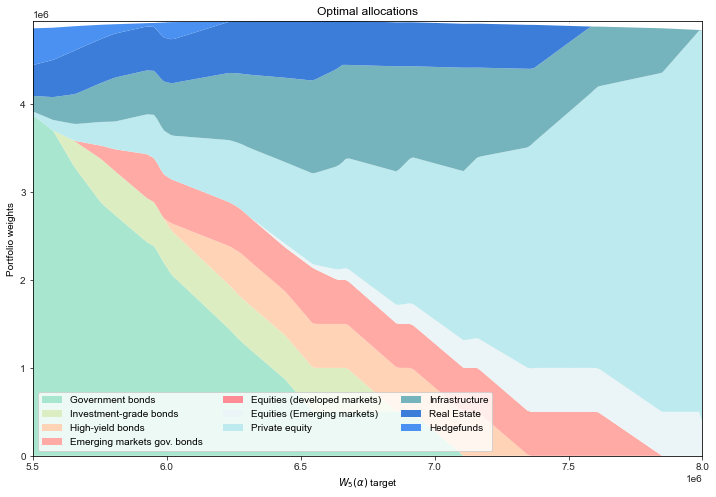

In [85]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.stackplot(w_targets, optimal_allocations.T, labels=asset_names);
ax.set_ylabel("Portfolio weights")
ax.set_xlabel("$W_5(\\alpha)$ target")
ax.set_title("Optimal allocations")
ax.legend(ncol=3, fontsize=10, loc="lower left");


In [86]:
"""
Calculate relative weights
"""
mv_init = np.sum(optimal_allocations, axis=1)

optimal_relative_weights = (1 / mv_init)[:, None] * optimal_allocations


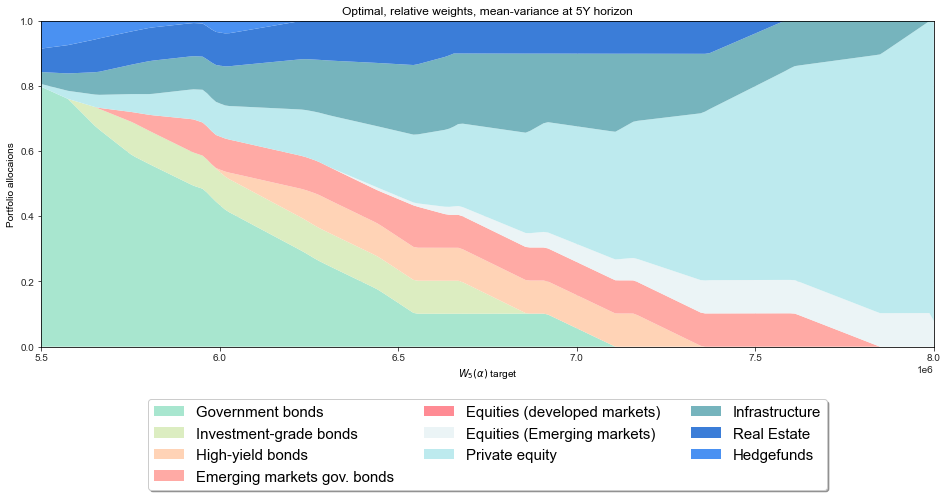

In [87]:
fig, ax = plt.subplots(figsize=(16, 6))

ax.stackplot(w_targets, optimal_relative_weights.T, labels=asset_names);
ax.set_xlabel("$W_5(\\alpha)$ target")
ax.set_ylabel("Portfolio allocaions")
ax.set_title("Optimal, relative weights, mean-variance at 5Y horizon")
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.3), fancybox=True, shadow=True, ncol=3);

In [88]:
"""
Calculate port. wealth
"""

port_wealth = np.apply_along_axis(calculate_wealth, 1, optimal_allocations, mu_l)

In [89]:
"""
Calculate port. std
"""

port_std = np.apply_along_axis(calculate_portfolio_std, 1, optimal_allocations, cov_mat_l)

In [90]:
gamma = -9
satisfactions = np.apply_along_axis(calculate_certainty_equivalent, 1,
                                    optimal_allocations, sim_prices, gamma)

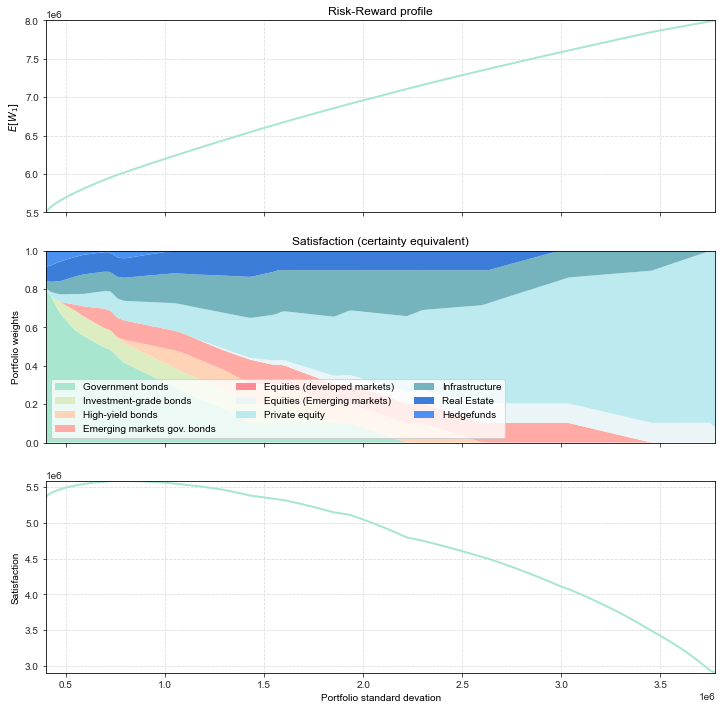

In [91]:
fig, ax = plt.subplots(3,1, figsize=(12, 12), sharex=True)

"""
Expected wealth
"""

ax[0].plot(port_std, port_wealth)
ax[0].set_ylabel("$E[W_1]$")
ax[0].title.set_text("Risk-Reward profile")

"""
Relative weights
"""

ax[1].stackplot(port_std, optimal_relative_weights.T, labels=asset_names);
ax[1].set_ylabel("Portfolio weights")
ax[1].set_title("Optimal, relative weights")
ax[1].legend(ncol=3, fontsize=10, loc="lower left");

"""
Satisfaction
"""
ax[2].plot(port_std, satisfactions)
ax[2].set_ylabel("Satisfaction")
ax[2].set_xlabel("Portfolio standard devation")
ax[1].set_title("Satisfaction (certainty equivalent)");

In [92]:
"""
Portfolio with highest satisfaction
"""

idx = np.argmax(satisfactions)

opt_alloc = optimal_allocations[idx, :]
opt_alloc

array([2.19065542e+06, 4.99999999e+05, 8.28101034e+03, 5.00000009e+05,
       3.46981124e-02, 1.02632487e-02, 5.00000041e+05, 5.57932548e+05,
       5.00000490e+05, 1.71759481e+05])

In [93]:
satisfactions[idx]

5584559.735662117

## Simulated wealth

In [94]:
alpha_init = np.repeat(500000.0, num_assets)
time_step = 1.0 / 12.0
num_periods = 60
time_points = np.arange(0, 5.0 + time_step, time_step)
num_sim = int(1e4)
sim_prices = np.exp(np.cumsum(np.random.multivariate_normal(mu * time_step, cov_mat * time_step,
                                                            size=(num_sim, num_periods)), axis=1))

sim_wealth = np.c_[np.ones(num_sim) * w0, sim_prices @ opt_alloc]

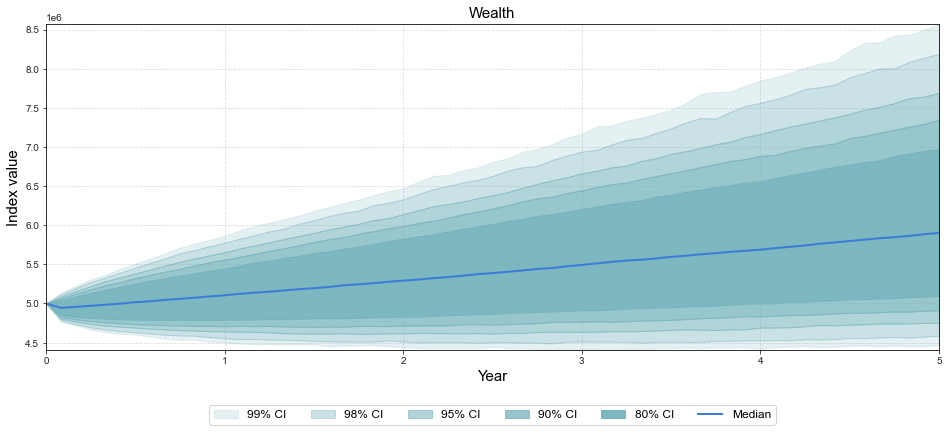

In [95]:
# calculate percentiles
percentiles_wealth = np.percentile(sim_wealth, [0.5, 1.0, 2.5, 5, 10, 50, 90, 95, 97.5, 99.0, 99.5],
                                         axis=0)

"""
Plot fan chart
"""

fig, ax = plt.subplots(figsize=(16, 6))

fan_chart(time_points,
          percentiles_wealth,
          color=default_colors['cyan'],
          color_median=default_colors['dark_blue'],
          labels=['99% CI', '98% CI', '95% CI', '90% CI', '80% CI', 'Median'],
          ax=ax)

ax.set_xlabel("Year", size=15)
ax.set_ylabel("Index value", size=15)
ax.set_title("Wealth", size=15)
#ax.set_ylim([0.5, 3.0])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=6, fontsize=12);

## Risk contribution 

We know that 

$$
\text{Var}[W_5] = \boldsymbol{\alpha}^\top  \text{Cov}[\mathbf{P}_{5}] \boldsymbol{\alpha}
$$

such that the standard deviation is given by, 

$$
\text{Sd}[W_5] = \sqrt{\boldsymbol{\alpha}^\top  \text{Cov}[\mathbf{P}_{5}] \boldsymbol{\alpha}}
$$

The Euler principle tells us that 

$$
\text{Sd}[W_5] = \boldsymbol{\alpha}^\top \frac{\boldsymbol{\Sigma} \boldsymbol{\alpha} }{\sqrt{\boldsymbol{\alpha}^\top \boldsymbol{\Sigma} \boldsymbol{\alpha}}} = \sum_{i=1}^N \alpha_i \frac{(\boldsymbol{\Sigma} \boldsymbol{\alpha})_i }{\sqrt{\boldsymbol{\alpha}^\top \boldsymbol{\Sigma} \boldsymbol{\alpha}}}
$$

In [96]:
risk_contribs = rb.calculate_risk_contributions_std(opt_alloc, cov_mat_l, scale=False)

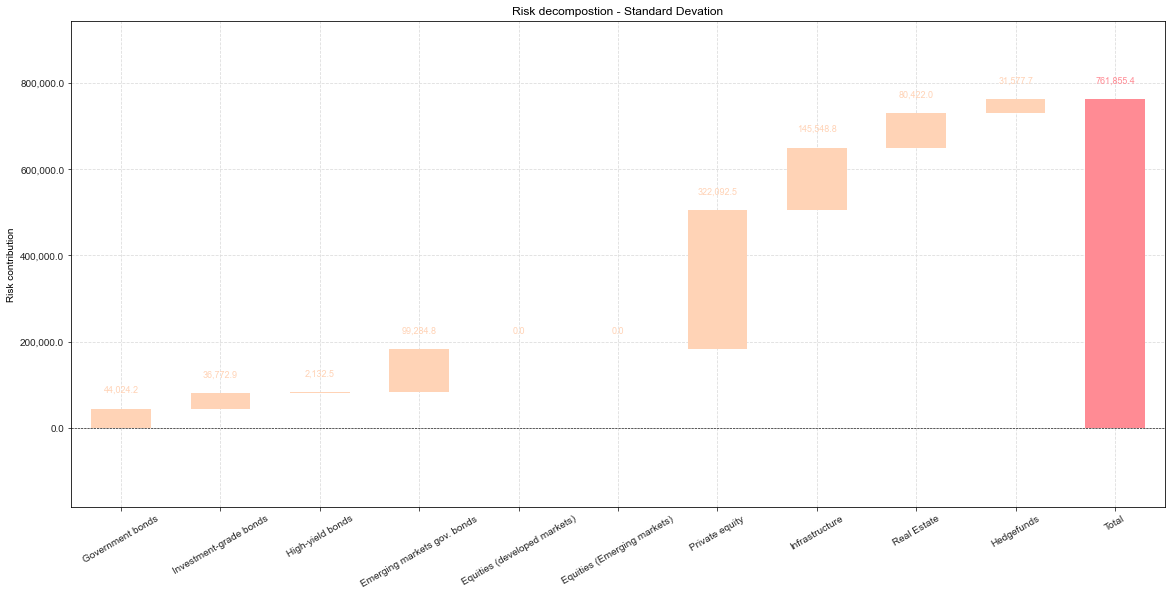

In [97]:
waterfall_chart(labels=asset_names, values=risk_contribs)

fig = plt.gcf()
ax = plt.gca()
fig.set_size_inches(18.5, 10.5)
ax.set_title('Risk decompostion - Standard Devation')
ax.set_ylabel('Risk contribution'); 

In [98]:
risk_contribs.sum()

761855.401458606

In [99]:
calculate_portfolio_std(opt_alloc, cov_mat_l)

761855.4014586059

If we instead want to use CVaR, we can use (when abstracting from the effect of transaction cost) 

$$
\text{CVaR}_{W_5} = \sum_{i=1}^N  \text{E}[P_i - 1 \vert W_5 - \mathbf{1}^\top \boldsymbol{\alpha}\leq \text{VaR}_{ W_5 - \mathbf{1}^\top \boldsymbol{\alpha}}] \alpha_i
$$                                          

Note that the wealth increase is given by $W_5 - \mathbf{1}^\top \boldsymbol{\alpha}$. 

Including the transaction costs

$$
\text{CVaR}_{W_5} = \sum_{i=1}^{N }  \text{E}[P_i - 1 \vert W_5 - \mathbf{1}^\top \boldsymbol{\alpha}\leq \text{VaR}_{ W_5 - \mathbf{1}^\top \boldsymbol{\alpha}}] \alpha_i + 1 \cdot (\mathbf{1}^\top \boldsymbol{\alpha} - \mathbf{1}^\top \boldsymbol{\alpha}_0)
$$                                          

Note that the wealth increase is given by $W_5 - W_0 = W_5 -  \mathbf{1}^\top \boldsymbol{\alpha} - \mathbf{k}^\top \vert \boldsymbol{\alpha} - \boldsymbol{\alpha}_0 \vert $. 

In [100]:
cost = - 1.0
alloc_cost = w0 - opt_alloc.sum()

In [101]:
#pnl_new = np.c_[pnl, np.ones(num_sum) * cost]
#opt_alloc_new = np.r_[opt_alloc, np.array(alloc_cost)]

In [102]:
pnl = sim_prices[:, -1, :] - 1
port_pnl = pnl @ opt_alloc
cvar_risk_contribs = calculate_risk_contributions_cvar(opt_alloc, pnl, p=0.05)

pnl_new = np.c_[pnl, np.ones(num_sim) * cost]
opt_alloc_new = np.r_[opt_alloc, np.array(alloc_cost)]
port_pnl_new = pnl_new @ opt_alloc_new
cvar_risk_contribs_new = calculate_risk_contributions_cvar(opt_alloc_new, pnl_new, p=0.05)

In [103]:
cvar= rm.calculate_conditional_value_at_risk(port_pnl, p=0.05)
cvar

-220543.48688997256

In [104]:
cvar_risk_contribs.sum()

-220543.48688997256

In [105]:
rm.calculate_conditional_value_at_risk(sim_wealth[:, -1] - w0, p=0.05)

-291914.4477314085

In [106]:
cvar_risk_contribs_new.sum()

-291914.4477314085

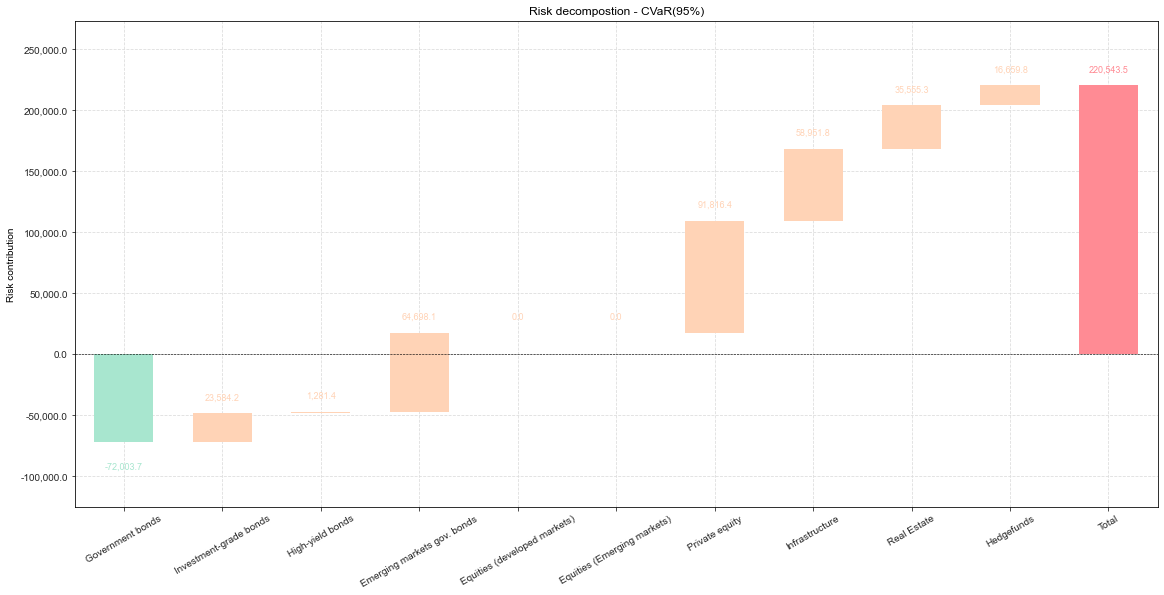

In [107]:
waterfall_chart(labels=asset_names, values=-cvar_risk_contribs)

fig = plt.gcf()
ax = plt.gca()
fig.set_size_inches(18.5, 10.5)
ax.set_title('Risk decompostion - CVaR(95%)')
ax.set_ylabel('Risk contribution'); 

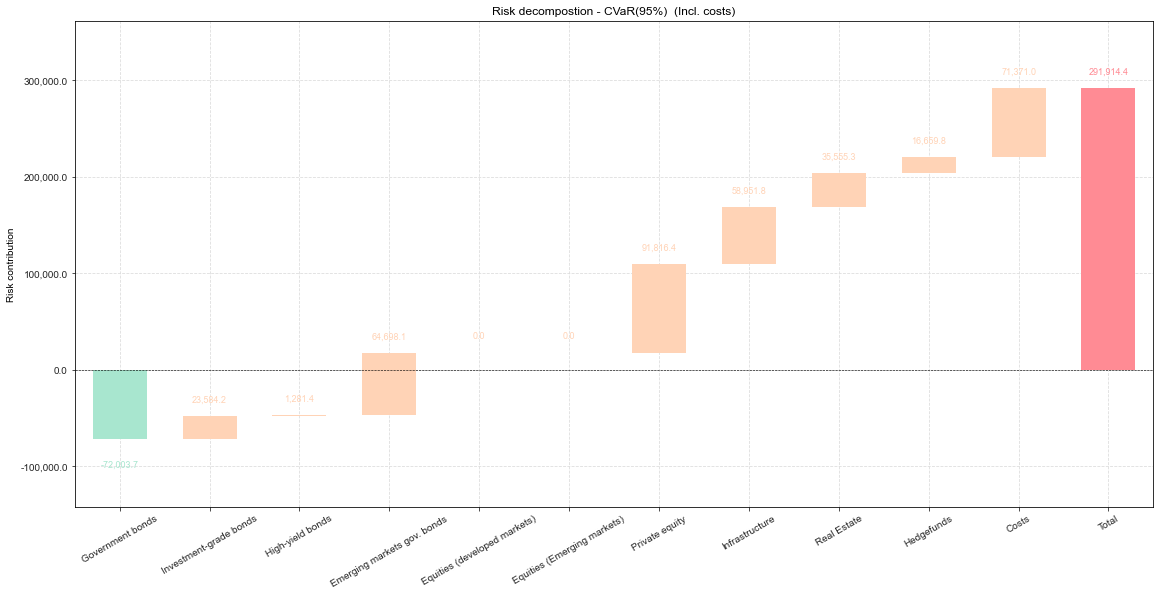

In [108]:
waterfall_chart(labels=asset_names + ['Costs'], values=-cvar_risk_contribs_new)

fig = plt.gcf()
ax = plt.gca()
fig.set_size_inches(18.5, 10.5)
ax.set_title('Risk decompostion - CVaR(95%)  (Incl. costs)')
ax.set_ylabel('Risk contribution'); 